In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e1/sample_submission.csv
/kaggle/input/playground-series-s5e1/train.csv
/kaggle/input/playground-series-s5e1/test.csv


In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')

# Load data
train = pd.read_csv('/kaggle/input/playground-series-s5e1/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e1/test.csv')
sample_submission = pd.read_csv('/kaggle/input/playground-series-s5e1/sample_submission.csv')

# Check the data
print(train.head())
print(test.head())


   id        date country              store             product  num_sold
0   0  2010-01-01  Canada  Discount Stickers   Holographic Goose       NaN
1   1  2010-01-01  Canada  Discount Stickers              Kaggle     973.0
2   2  2010-01-01  Canada  Discount Stickers        Kaggle Tiers     906.0
3   3  2010-01-01  Canada  Discount Stickers            Kerneler     423.0
4   4  2010-01-01  Canada  Discount Stickers  Kerneler Dark Mode     491.0
       id        date country              store             product
0  230130  2017-01-01  Canada  Discount Stickers   Holographic Goose
1  230131  2017-01-01  Canada  Discount Stickers              Kaggle
2  230132  2017-01-01  Canada  Discount Stickers        Kaggle Tiers
3  230133  2017-01-01  Canada  Discount Stickers            Kerneler
4  230134  2017-01-01  Canada  Discount Stickers  Kerneler Dark Mode


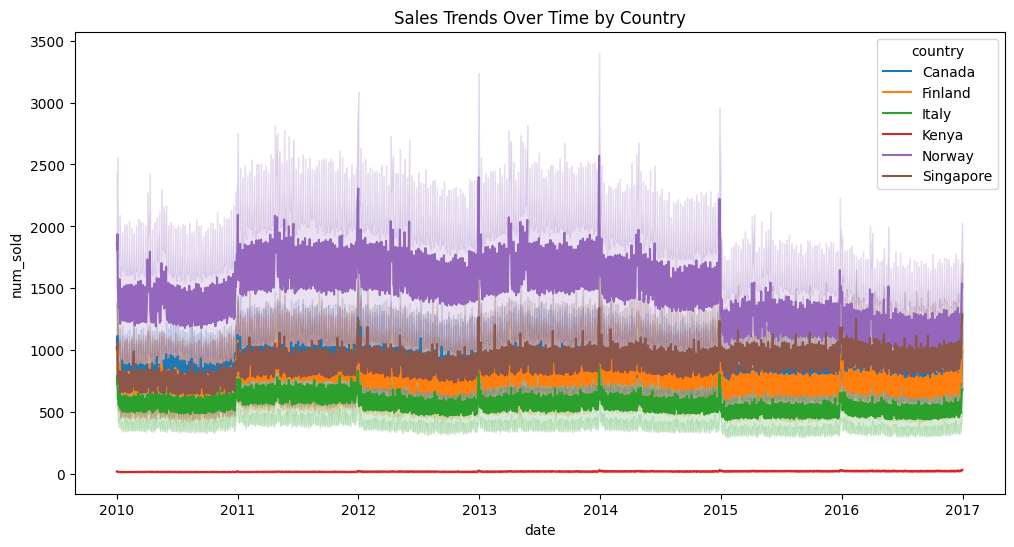

In [3]:
# Convert date to datetime format
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

# Plot sales trends
plt.figure(figsize=(12, 6))
sns.lineplot(data=train, x='date', y='num_sold', hue='country')
plt.title('Sales Trends Over Time by Country')
plt.show()


In [4]:
# Add date-related features
def feature_engineering(df):
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['day_of_week'] = df['date'].dt.dayofweek
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
    return df

train = feature_engineering(train)
test = feature_engineering(test)

# Encode categorical features
train = pd.get_dummies(train, columns=['country', 'store', 'product'], drop_first=True)
test = pd.get_dummies(test, columns=['country', 'store', 'product'], drop_first=True)

print(train.head())


   id       date  num_sold  year  month  day  day_of_week  is_weekend  \
0   0 2010-01-01       NaN  2010      1    1            4           0   
1   1 2010-01-01     973.0  2010      1    1            4           0   
2   2 2010-01-01     906.0  2010      1    1            4           0   
3   3 2010-01-01     423.0  2010      1    1            4           0   
4   4 2010-01-01     491.0  2010      1    1            4           0   

   country_Finland  country_Italy  country_Kenya  country_Norway  \
0            False          False          False           False   
1            False          False          False           False   
2            False          False          False           False   
3            False          False          False           False   
4            False          False          False           False   

   country_Singapore  store_Premium Sticker Mart  store_Stickers for Less  \
0              False                       False                    False  

In [5]:
print(train.columns)


Index(['id', 'date', 'num_sold', 'year', 'month', 'day', 'day_of_week',
       'is_weekend', 'country_Finland', 'country_Italy', 'country_Kenya',
       'country_Norway', 'country_Singapore', 'store_Premium Sticker Mart',
       'store_Stickers for Less', 'product_Kaggle', 'product_Kaggle Tiers',
       'product_Kerneler', 'product_Kerneler Dark Mode'],
      dtype='object')


In [6]:
y = train['num_sold']  # Correct column name


In [7]:
print(train.columns)


Index(['id', 'date', 'num_sold', 'year', 'month', 'day', 'day_of_week',
       'is_weekend', 'country_Finland', 'country_Italy', 'country_Kenya',
       'country_Norway', 'country_Singapore', 'store_Premium Sticker Mart',
       'store_Stickers for Less', 'product_Kaggle', 'product_Kaggle Tiers',
       'product_Kerneler', 'product_Kerneler Dark Mode'],
      dtype='object')


In [8]:
train.rename(columns={'num_sold_x': 'num_sold'}, inplace=True)


In [9]:
print(train.columns)


Index(['id', 'date', 'num_sold', 'year', 'month', 'day', 'day_of_week',
       'is_weekend', 'country_Finland', 'country_Italy', 'country_Kenya',
       'country_Norway', 'country_Singapore', 'store_Premium Sticker Mart',
       'store_Stickers for Less', 'product_Kaggle', 'product_Kaggle Tiers',
       'product_Kerneler', 'product_Kerneler Dark Mode'],
      dtype='object')


In [10]:
y = train['num_sold']  # Update 'num_sold_x' to the correct name


In [11]:
print(f"Number of NaN values in y: {train['num_sold'].isna().sum()}")


Number of NaN values in y: 8871


In [12]:
train['num_sold'].fillna(train['num_sold'].mean(), inplace=True)


In [13]:
y = train['num_sold']


In [14]:
y = train['num_sold']  # Use the renamed column
print(f"Number of NaN values in y: {y.isna().sum()}")

# Option 1: Fill missing values (if needed)
y.fillna(y.mean(), inplace=True)


Number of NaN values in y: 0


In [15]:
print(f"Number of NaN values in y: {y.isna().sum()}")


Number of NaN values in y: 0


In [16]:
print(train.columns)


Index(['id', 'date', 'num_sold', 'year', 'month', 'day', 'day_of_week',
       'is_weekend', 'country_Finland', 'country_Italy', 'country_Kenya',
       'country_Norway', 'country_Singapore', 'store_Premium Sticker Mart',
       'store_Stickers for Less', 'product_Kaggle', 'product_Kaggle Tiers',
       'product_Kerneler', 'product_Kerneler Dark Mode'],
      dtype='object')


In [17]:
X = train.drop(columns=['num_sold'])  # Replace 'num_sold' with the target column name


In [18]:
# Define features (X) and target (y)
X = train.drop(columns=['num_sold'])  # Replace 'num_sold' with the correct target column name
y = train['num_sold']  # Replace 'num_sold' with the correct target column name

# Proceed with TimeSeriesSplit and model training
tscv = TimeSeriesSplit(n_splits=5)
for train_idx, val_idx in tscv.split(X):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Train your model here


In [19]:
print(train.columns)


Index(['id', 'date', 'num_sold', 'year', 'month', 'day', 'day_of_week',
       'is_weekend', 'country_Finland', 'country_Italy', 'country_Kenya',
       'country_Norway', 'country_Singapore', 'store_Premium Sticker Mart',
       'store_Stickers for Less', 'product_Kaggle', 'product_Kaggle Tiers',
       'product_Kerneler', 'product_Kerneler Dark Mode'],
      dtype='object')


In [20]:
# Add lag features
for lag in [7, 14]:
    train[f'lag_{lag}'] = train['num_sold'].shift(lag)
    test[f'lag_{lag}'] = 0  # Initialize test with zeros as it lacks historical data

# Add rolling mean features
train['rolling_mean_7'] = train['num_sold'].rolling(window=7, min_periods=1).mean()
train['rolling_mean_14'] = train['num_sold'].rolling(window=14, min_periods=1).mean()

test['rolling_mean_7'] = 0  # Initialize test with zeros
test['rolling_mean_14'] = 0

# Fill missing values created by shifting (at the start of the data)
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

# Check the new features
print(train.head())
print(test.head())


   id       date    num_sold  year  month  day  day_of_week  is_weekend  \
0   0 2010-01-01  752.527382  2010      1    1            4           0   
1   1 2010-01-01  973.000000  2010      1    1            4           0   
2   2 2010-01-01  906.000000  2010      1    1            4           0   
3   3 2010-01-01  423.000000  2010      1    1            4           0   
4   4 2010-01-01  491.000000  2010      1    1            4           0   

   country_Finland  country_Italy  ...  store_Premium Sticker Mart  \
0            False          False  ...                       False   
1            False          False  ...                       False   
2            False          False  ...                       False   
3            False          False  ...                       False   
4            False          False  ...                       False   

   store_Stickers for Less  product_Kaggle  product_Kaggle Tiers  \
0                    False           False                 F

In [21]:
from sklearn.model_selection import train_test_split

# Define features and target
features = [col for col in train.columns if col not in ['id', 'date', 'num_sold']]
X = train[features]
y = train['num_sold']

# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")


Training data shape: (184104, 20)
Validation data shape: (46026, 20)


In [22]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error

# Initialize XGBoost model
xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    random_state=42
)

# Train the model
xgb_model.fit(X_train, y_train)

# Evaluate the model
y_pred = xgb_model.predict(X_val)
mape_score = mean_absolute_percentage_error(y_val, y_pred)
print(f"MAPE on Validation Set: {mape_score:.4f}")


MAPE on Validation Set: 0.2426


In [23]:
from sklearn.model_selection import RandomizedSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
}

# Perform Randomized Search
random_search = RandomizedSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_distributions=param_grid,
    n_iter=20,
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=2,
    random_state=42,
)

random_search.fit(X_train, y_train)

# Use the best model
best_model = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)

# Evaluate the tuned model
y_pred_best = best_model.predict(X_val)
mape_best = mean_absolute_percentage_error(y_val, y_pred_best)
print(f"MAPE with Tuned Model: {mape_best:.4f}")


Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END learning_rate=0.05, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.7s
[CV] END learning_rate=0.05, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.7s
[CV] END learning_rate=0.05, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.7s
[CV] END learning_rate=0.1, max_depth=9, n_estimators=100, subsample=1.0; total time=   1.6s
[CV] END learning_rate=0.1, max_depth=9, n_estimators=100, subsample=1.0; total time=   1.7s
[CV] END learning_rate=0.1, max_depth=9, n_estimators=100, subsample=1.0; total time=   1.6s
[CV] END learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.8; total time=   1.6s
[CV] END learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.8; total time=   1.6s
[CV] END learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.8; total time=   1.6s
[CV] END learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.8; total time=   1.6s
[CV] 

In [24]:
# Create holiday features (example for global holidays, adjust as needed)
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()
holidays = cal.holidays(start=train['date'].min(), end=train['date'].max())
train['is_holiday'] = train['date'].isin(holidays).astype(int)
test['is_holiday'] = test['date'].isin(holidays).astype(int)

# Add month and seasonality as categorical features
train['season'] = train['month'] % 12 // 3  # 0: Winter, 1: Spring, 2: Summer, 3: Autumn
test['season'] = test['month'] % 12 // 3


In [25]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge

# Base models
base_models = [
    ('xgb', XGBRegressor(random_state=42)),
    ('gb', GradientBoostingRegressor(random_state=42)),
]

# Stacking model
stacked_model = StackingRegressor(
    estimators=base_models,
    final_estimator=Ridge()
)

stacked_model.fit(X_train, y_train)

# Evaluate
y_pred_stack = stacked_model.predict(X_val)
mape_stack = mean_absolute_percentage_error(y_val, y_pred_stack)
print(f'MAPE with Stacked Model: {mape_stack:.4f}')


MAPE with Stacked Model: 0.2358


In [26]:
# Get predictions from individual models
xgb_pred = xgb_model.predict(X_val)
gb_pred = GradientBoostingRegressor(random_state=42).fit(X_train, y_train).predict(X_val)

# Blend predictions (weighted average)
blended_pred = 0.6 * xgb_pred + 0.4 * gb_pred
mape_blended = mean_absolute_percentage_error(y_val, blended_pred)
print(f'MAPE with Blended Model: {mape_blended:.4f}')


MAPE with Blended Model: 0.3399


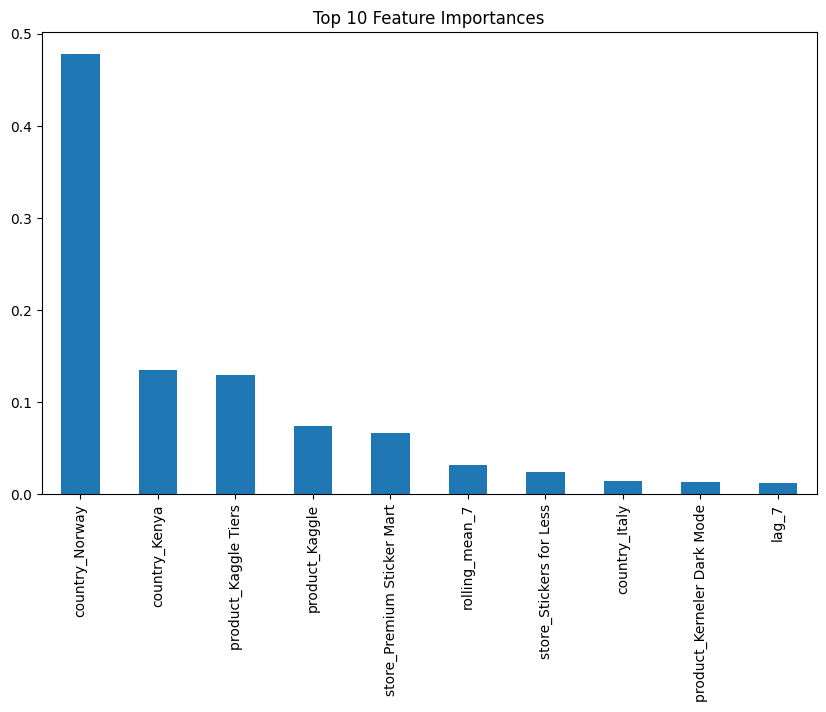

In [27]:
import matplotlib.pyplot as plt

# Feature importance from XGBoost
feature_importances = pd.Series(xgb_model.feature_importances_, index=features)
feature_importances.sort_values(ascending=False).head(10).plot(kind='bar', figsize=(10, 6))
plt.title('Top 10 Feature Importances')
plt.show()


In [28]:
import numpy as np

# Add Fourier terms for seasonality
train['fourier_sin_12'] = np.sin(2 * np.pi * train['day'] / 12)
train['fourier_cos_12'] = np.cos(2 * np.pi * train['day'] / 12)

test['fourier_sin_12'] = np.sin(2 * np.pi * test['day'] / 12)
test['fourier_cos_12'] = np.cos(2 * np.pi * test['day'] / 12)


In [29]:
from sklearn.feature_selection import RFECV

selector = RFECV(estimator=xgb_model, step=1, cv=5, scoring='neg_mean_absolute_error')
selector = selector.fit(X_train, y_train)

# Update X_train and X_val with selected features
X_train = selector.transform(X_train)
X_val = selector.transform(X_val)

print(f"Optimal number of features: {selector.n_features_}")


Optimal number of features: 16


In [30]:
X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val_lstm = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))


In [31]:
print(f"X_train_lstm shape: {X_train_lstm.shape}")
print(f"X_val_lstm shape: {X_val_lstm.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")


X_train_lstm shape: (184104, 16, 1)
X_val_lstm shape: (46026, 16, 1)
y_train shape: (184104,)
y_val shape: (46026,)


In [32]:
# Ensure X_train_lstm and X_val_lstm are 3D
X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val_lstm = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

print("Reshaped X_train_lstm:", X_train_lstm.shape)
print("Reshaped X_val_lstm:", X_val_lstm.shape)


Reshaped X_train_lstm: (184104, 16, 1)
Reshaped X_val_lstm: (46026, 16, 1)


In [33]:
# Define features and target
X = train.drop(columns=['num_sold'])  # Adjust 'num_sold' to your target column name
y = train['num_sold']

# Split into train/validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dense(1)  # Output layer for regression
])
model.compile(optimizer='adam', loss='mean_squared_error')


In [35]:
# Predict and flatten output
y_pred_attention = model.predict(X_val_lstm).flatten()
print("Flattened y_pred_attention shape:", y_pred_attention.shape)


1439/1439 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
Flattened y_pred_attention shape: (46026,)


In [36]:
model.fit(X_train_lstm, y_train, epochs=10, batch_size=32, validation_data=(X_val_lstm, y_val))


Epoch 1/10
5754/5754 ━━━━━━━━━━━━━━━━━━━━ 50s 8ms/step - loss: 557848.3750 - val_loss: 464952.4688
Epoch 2/10
5754/5754 ━━━━━━━━━━━━━━━━━━━━ 47s 8ms/step - loss: 463546.1562 - val_loss: 478044.4688
Epoch 3/10
5754/5754 ━━━━━━━━━━━━━━━━━━━━ 47s 8ms/step - loss: 463717.6875 - val_loss: 459803.9375
Epoch 4/10
5754/5754 ━━━━━━━━━━━━━━━━━━━━ 47s 8ms/step - loss: 460692.9688 - val_loss: 459644.2500
Epoch 5/10
5754/5754 ━━━━━━━━━━━━━━━━━━━━ 48s 8ms/step - loss: 460675.9375 - val_loss: 459471.6875
Epoch 6/10
5754/5754 ━━━━━━━━━━━━━━━━━━━━ 47s 8ms/step - loss: 463517.6562 - val_loss: 466158.0625
Epoch 7/10
5754/5754 ━━━━━━━━━━━━━━━━━━━━ 47s 8ms/step - loss: 467451.0000 - val_loss: 461919.6250
Epoch 8/10
5754/5754 ━━━━━━━━━━━━━━━━━━━━ 47s 8ms/step - loss: 464477.0938 - val_loss: 460219.0000
Epoch 9/10
5754/5754 ━━━━━━━━━━━━━━━━━━━━ 47s 8ms/step - loss: 457150.9688 - val_loss: 459451.8750
Epoch 10/10
5754/5754 ━━━━━━━━━━━━━━━━━━━━ 47s 8ms/step - loss: 456501.0000 - val_loss: 461729.5312


In [37]:
if len(y_val) != len(y_pred_attention):
    print("Mismatch detected!")
    print(f"Length of y_val: {len(y_val)}, Length of y_pred_attention: {len(y_pred_attention)}")


In [38]:
# Align y_val and y_pred_attention
min_length = min(len(y_val), len(y_pred_attention))
y_val = y_val[:min_length]
y_pred_attention = y_pred_attention[:min_length]


In [39]:
# Compute MAPE
mape_attention = mean_absolute_percentage_error(y_val, y_pred_attention)
print(f"MAPE with Attention: {mape_attention:.4f}")


MAPE with Attention: 1.0344


In [40]:
# Convert datetime column to numeric features
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['day'] = train['date'].dt.day
train['weekday'] = train['date'].dt.weekday

# Drop the original datetime column if it's no longer needed
train = train.drop(columns=['date'])


In [41]:
print(train.columns)


Index(['id', 'num_sold', 'year', 'month', 'day', 'day_of_week', 'is_weekend',
       'country_Finland', 'country_Italy', 'country_Kenya', 'country_Norway',
       'country_Singapore', 'store_Premium Sticker Mart',
       'store_Stickers for Less', 'product_Kaggle', 'product_Kaggle Tiers',
       'product_Kerneler', 'product_Kerneler Dark Mode', 'lag_7', 'lag_14',
       'rolling_mean_7', 'rolling_mean_14', 'is_holiday', 'season',
       'fourier_sin_12', 'fourier_cos_12', 'weekday'],
      dtype='object')


In [42]:
train = train.drop(columns=['date'], errors='ignore')



In [43]:
# Check the columns in the DataFrame
print(train.columns)

# If 'date' column exists, preprocess it
if 'date' in train.columns:
    train['year'] = train['date'].dt.year
    train['month'] = train['date'].dt.month
    train['day'] = train['date'].dt.day
    train['weekday'] = train['date'].dt.weekday
    train = train.drop(columns=['date'])  # Drop datetime column if necessary
else:
    print("The 'date' column is not present in the DataFrame.")


Index(['id', 'num_sold', 'year', 'month', 'day', 'day_of_week', 'is_weekend',
       'country_Finland', 'country_Italy', 'country_Kenya', 'country_Norway',
       'country_Singapore', 'store_Premium Sticker Mart',
       'store_Stickers for Less', 'product_Kaggle', 'product_Kaggle Tiers',
       'product_Kerneler', 'product_Kerneler Dark Mode', 'lag_7', 'lag_14',
       'rolling_mean_7', 'rolling_mean_14', 'is_holiday', 'season',
       'fourier_sin_12', 'fourier_cos_12', 'weekday'],
      dtype='object')
The 'date' column is not present in the DataFrame.


In [44]:
print(train.dtypes)


id                              int64
num_sold                      float64
year                            int32
month                           int32
day                             int32
day_of_week                     int32
is_weekend                      int64
country_Finland                  bool
country_Italy                    bool
country_Kenya                    bool
country_Norway                   bool
country_Singapore                bool
store_Premium Sticker Mart       bool
store_Stickers for Less          bool
product_Kaggle                   bool
product_Kaggle Tiers             bool
product_Kerneler                 bool
product_Kerneler Dark Mode       bool
lag_7                         float64
lag_14                        float64
rolling_mean_7                float64
rolling_mean_14               float64
is_holiday                      int64
season                          int32
fourier_sin_12                float64
fourier_cos_12                float64
weekday     

In [45]:
if 'date' in train.columns:
    train['year'] = train['date'].dt.year
    train['month'] = train['date'].dt.month
    train['day'] = train['date'].dt.day
    train['weekday'] = train['date'].dt.weekday
    train = train.drop(columns=['date'])
else:
    print("The 'date' column is not present in the DataFrame.")


The 'date' column is not present in the DataFrame.


In [46]:
print(train.dtypes)


id                              int64
num_sold                      float64
year                            int32
month                           int32
day                             int32
day_of_week                     int32
is_weekend                      int64
country_Finland                  bool
country_Italy                    bool
country_Kenya                    bool
country_Norway                   bool
country_Singapore                bool
store_Premium Sticker Mart       bool
store_Stickers for Less          bool
product_Kaggle                   bool
product_Kaggle Tiers             bool
product_Kerneler                 bool
product_Kerneler Dark Mode       bool
lag_7                         float64
lag_14                        float64
rolling_mean_7                float64
rolling_mean_14               float64
is_holiday                      int64
season                          int32
fourier_sin_12                float64
fourier_cos_12                float64
weekday     

In [47]:
from sklearn.preprocessing import LabelEncoder

for col in train.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])


In [48]:
train = train.select_dtypes(include=['int64', 'float64', 'bool', 'int32', 'float32'])


In [49]:
xgb_model = XGBRegressor(random_state=42, enable_categorical=True)


In [50]:
print(train.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230130 entries, 0 to 230129
Data columns (total 27 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          230130 non-null  int64  
 1   num_sold                    230130 non-null  float64
 2   year                        230130 non-null  int32  
 3   month                       230130 non-null  int32  
 4   day                         230130 non-null  int32  
 5   day_of_week                 230130 non-null  int32  
 6   is_weekend                  230130 non-null  int64  
 7   country_Finland             230130 non-null  bool   
 8   country_Italy               230130 non-null  bool   
 9   country_Kenya               230130 non-null  bool   
 10  country_Norway              230130 non-null  bool   
 11  country_Singapore           230130 non-null  bool   
 12  store_Premium Sticker Mart  230130 non-null  bool   
 13  store_Stickers

In [51]:
train = train.select_dtypes(include=['int64', 'float64', 'bool', 'int32', 'float32'])


In [52]:
print(train.head())
print(train.dtypes)


   id    num_sold  year  month  day  day_of_week  is_weekend  country_Finland  \
0   0  752.527382  2010      1    1            4           0            False   
1   1  973.000000  2010      1    1            4           0            False   
2   2  906.000000  2010      1    1            4           0            False   
3   3  423.000000  2010      1    1            4           0            False   
4   4  491.000000  2010      1    1            4           0            False   

   country_Italy  country_Kenya  ...  product_Kerneler Dark Mode  lag_7  \
0          False          False  ...                       False    0.0   
1          False          False  ...                       False    0.0   
2          False          False  ...                       False    0.0   
3          False          False  ...                       False    0.0   
4          False          False  ...                        True    0.0   

   lag_14  rolling_mean_7  rolling_mean_14  is_holiday  season

In [53]:
from sklearn.model_selection import train_test_split

# Define X (features) and y (target)
X = train.drop(columns=['num_sold'])  # Replace 'num_sold' with your target column
y = train['num_sold']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [54]:
xgb_model = XGBRegressor(random_state=42, enable_categorical=True)
xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [55]:
y_pred = xgb_model.predict(X_test)


In [56]:
from sklearn.metrics import mean_absolute_percentage_error

mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE: {mape:.4f}")


MAPE: 0.2090


In [57]:
# Initialize the 'num_sold' column in the test dataset with zeros
test['num_sold'] = 0  # Placeholder for predictions

# Create lag features in the training dataset
train['dynamic_lag_1'] = train['num_sold'].shift(1)
train['dynamic_lag_2'] = train['num_sold'].shift(2)

# Fill missing values for lags in the training dataset
train.fillna(0, inplace=True)

# At test time, update lags recursively
for i in range(len(test)):
    test.loc[i, 'dynamic_lag_1'] = test['num_sold'].iloc[i - 1] if i > 0 else 0
    test.loc[i, 'dynamic_lag_2'] = test['num_sold'].iloc[i - 2] if i > 1 else 0



In [58]:
X_train = X_train.select_dtypes(include=['int64', 'float64', 'bool', 'int32', 'float32'])
X_val = X_val.select_dtypes(include=['int64', 'float64', 'bool', 'int32', 'float32'])


In [59]:
print("X_train dtypes:", X_train.dtypes)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val dtypes:", X_val.dtypes)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)


X_train dtypes: id                              int64
year                            int32
month                           int32
day                             int32
day_of_week                     int32
is_weekend                      int64
country_Finland                  bool
country_Italy                    bool
country_Kenya                    bool
country_Norway                   bool
country_Singapore                bool
store_Premium Sticker Mart       bool
store_Stickers for Less          bool
product_Kaggle                   bool
product_Kaggle Tiers             bool
product_Kerneler                 bool
product_Kerneler Dark Mode       bool
lag_7                         float64
lag_14                        float64
rolling_mean_7                float64
rolling_mean_14               float64
is_holiday                      int64
season                          int32
fourier_sin_12                float64
fourier_cos_12                float64
weekday                         in

In [60]:
X_train.fillna(0, inplace=True)
X_val.fillna(0, inplace=True)


In [61]:
print("X_train columns:", X_train.columns)
print("X_val columns:", X_val.columns)


X_train columns: Index(['id', 'year', 'month', 'day', 'day_of_week', 'is_weekend',
       'country_Finland', 'country_Italy', 'country_Kenya', 'country_Norway',
       'country_Singapore', 'store_Premium Sticker Mart',
       'store_Stickers for Less', 'product_Kaggle', 'product_Kaggle Tiers',
       'product_Kerneler', 'product_Kerneler Dark Mode', 'lag_7', 'lag_14',
       'rolling_mean_7', 'rolling_mean_14', 'is_holiday', 'season',
       'fourier_sin_12', 'fourier_cos_12', 'weekday'],
      dtype='object')
X_val columns: Index(['id', 'year', 'month', 'day', 'day_of_week', 'is_weekend',
       'country_Finland', 'country_Italy', 'country_Kenya', 'country_Norway',
       'country_Singapore', 'store_Premium Sticker Mart',
       'store_Stickers for Less', 'product_Kaggle', 'product_Kaggle Tiers',
       'product_Kerneler', 'product_Kerneler Dark Mode', 'lag_7', 'lag_14',
       'rolling_mean_7', 'rolling_mean_14', 'is_holiday', 'season',
       'fourier_sin_12', 'fourier_cos_12'],
   

In [62]:
print(X_train.columns)
print(X_val.columns)


Index(['id', 'year', 'month', 'day', 'day_of_week', 'is_weekend',
       'country_Finland', 'country_Italy', 'country_Kenya', 'country_Norway',
       'country_Singapore', 'store_Premium Sticker Mart',
       'store_Stickers for Less', 'product_Kaggle', 'product_Kaggle Tiers',
       'product_Kerneler', 'product_Kerneler Dark Mode', 'lag_7', 'lag_14',
       'rolling_mean_7', 'rolling_mean_14', 'is_holiday', 'season',
       'fourier_sin_12', 'fourier_cos_12', 'weekday'],
      dtype='object')
Index(['id', 'year', 'month', 'day', 'day_of_week', 'is_weekend',
       'country_Finland', 'country_Italy', 'country_Kenya', 'country_Norway',
       'country_Singapore', 'store_Premium Sticker Mart',
       'store_Stickers for Less', 'product_Kaggle', 'product_Kaggle Tiers',
       'product_Kerneler', 'product_Kerneler Dark Mode', 'lag_7', 'lag_14',
       'rolling_mean_7', 'rolling_mean_14', 'is_holiday', 'season',
       'fourier_sin_12', 'fourier_cos_12'],
      dtype='object')


In [63]:
common_columns = X_train.columns.intersection(X_val.columns)
X_train = X_train[common_columns]
X_val = X_val[common_columns]


In [64]:
print("X_train columns:", X_train.columns)
print("X_val columns:", X_val.columns)


X_train columns: Index(['id', 'year', 'month', 'day', 'day_of_week', 'is_weekend',
       'country_Finland', 'country_Italy', 'country_Kenya', 'country_Norway',
       'country_Singapore', 'store_Premium Sticker Mart',
       'store_Stickers for Less', 'product_Kaggle', 'product_Kaggle Tiers',
       'product_Kerneler', 'product_Kerneler Dark Mode', 'lag_7', 'lag_14',
       'rolling_mean_7', 'rolling_mean_14', 'is_holiday', 'season',
       'fourier_sin_12', 'fourier_cos_12'],
      dtype='object')
X_val columns: Index(['id', 'year', 'month', 'day', 'day_of_week', 'is_weekend',
       'country_Finland', 'country_Italy', 'country_Kenya', 'country_Norway',
       'country_Singapore', 'store_Premium Sticker Mart',
       'store_Stickers for Less', 'product_Kaggle', 'product_Kaggle Tiers',
       'product_Kerneler', 'product_Kerneler Dark Mode', 'lag_7', 'lag_14',
       'rolling_mean_7', 'rolling_mean_14', 'is_holiday', 'season',
       'fourier_sin_12', 'fourier_cos_12'],
      dtype='o

In [65]:
from xgboost import XGBRegressor
model = XGBRegressor(random_state=42, enable_categorical=True)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)
from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(y_val, y_pred)
print(f"MAPE: {mape}")


MAPE: 0.20903120666653668


In [66]:
columns_to_use = X_train.columns
X_train = X_train[columns_to_use]
X_val = X_val[columns_to_use]


In [67]:
from bayes_opt import BayesianOptimization

# Define the function to optimize
def xgb_evaluate(n_estimators, learning_rate, max_depth):
    xgb_bo = XGBRegressor(
        n_estimators=int(n_estimators),
        learning_rate=learning_rate,
        max_depth=int(max_depth),
        random_state=42
    )
    xgb_bo.fit(X_train, y_train)
    y_pred_bo = xgb_bo.predict(X_val)
    return -mean_absolute_percentage_error(y_val, y_pred_bo)

# Define the parameter space
param_bounds = {
    'n_estimators': (100, 500),
    'learning_rate': (0.01, 0.2),
    'max_depth': (3, 10)
}

# Run Bayesian Optimization
optimizer = BayesianOptimization(f=xgb_evaluate, pbounds=param_bounds, random_state=42)
optimizer.maximize(init_points=5, n_iter=25)

# Train the model with best parameters
best_params = optimizer.max
print(best_params)


|   iter    |  target   | learni... | max_depth | n_esti... |
-------------------------------------------------------------
| 1         | -0.07269  | 0.08116   | 9.655     | 392.8     |
| 2         | -0.401    | 0.1237    | 4.092     | 162.4     |
| 3         | -0.08224  | 0.02104   | 9.063     | 340.4     |
| 4         | -0.4931   | 0.1445    | 3.144     | 488.0     |
| 5         | -0.4015   | 0.1682    | 4.486     | 172.7     |
| 6         | -0.7094   | 0.0413    | 3.295     | 281.6     |
| 7         | -0.08648  | 0.1585    | 8.485     | 392.9     |
| 8         | -0.07347  | 0.1054    | 9.967     | 366.3     |
| 9         | -0.2235   | 0.1729    | 6.794     | 100.0     |
| 10        | -0.07314  | 0.04843   | 9.839     | 428.0     |
| 11        | -0.07427  | 0.1076    | 9.998     | 410.3     |
| 12        | -0.07478  | 0.03546   | 9.828     | 448.0     |
| 13        | -0.07985  | 0.04195   | 9.883     | 221.0     |
| 14        | -0.7462   | 0.04189   | 3.078     | 235.6     |
| 15    

In [68]:
!pip install prophet


In [69]:
print("Length of train dataset:", len(train))


Length of train dataset: 230130


In [70]:
# Limit the train dataset to the first 10,000 rows for testing purposes
train = train.iloc[:10000]

# Generate sequential dates for the subset
train['date'] = pd.date_range(start='2010-01-01', periods=len(train), freq='D')

print(train['date'].head())


0   2010-01-01
1   2010-01-02
2   2010-01-03
3   2010-01-04
4   2010-01-05
Name: date, dtype: datetime64[ns]


In [71]:
# Limit the train dataset to the first 10,000 rows for testing
train = train.iloc[:10000]

# Generate sequential dates for this subset
train['date'] = pd.date_range(start='2010-01-01', periods=len(train), freq='D')

# Check if the date column has been updated
print(train['date'].head())
print(train['date'].nunique())  # Should match the dataset length


0   2010-01-01
1   2010-01-02
2   2010-01-03
3   2010-01-04
4   2010-01-05
Name: date, dtype: datetime64[ns]
10000


In [72]:
from prophet import Prophet

# Rename columns for Prophet compatibility
df = train[['date', 'num_sold']].rename(columns={'date': 'ds', 'num_sold': 'y'})
print(df.head())  # Check the prepared DataFrame


          ds           y
0 2010-01-01  752.527382
1 2010-01-02  973.000000
2 2010-01-03  906.000000
3 2010-01-04  423.000000
4 2010-01-05  491.000000


In [73]:
# Initialize and fit Prophet model
model = Prophet()
model.fit(df)


14:30:14 - cmdstanpy - INFO - Chain [1] start processing
14:30:14 - cmdstanpy - INFO - Chain [1] done processing


In [74]:
# Generate a future dataframe with periods matching the test dataset
future = model.make_future_dataframe(periods=365, freq='D')  # Adjust as needed
forecast = model.predict(future)

# Inspect the forecasted DataFrame
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())


              ds        yhat  yhat_lower   yhat_upper
10360 2038-05-14  739.601180  -73.183091  1473.930674
10361 2038-05-15  741.165303  -35.342111  1465.840658
10362 2038-05-16  746.526567   -0.163736  1562.832576
10363 2038-05-17  740.906006  -72.883991  1516.274573
10364 2038-05-18  732.760477  -43.837751  1570.904149


In [75]:
# Limit the test dataset to a reasonable size for comparison
test = test.iloc[:365]

# Merge predictions back to the test dataset
test['num_sold'] = forecast['yhat'].iloc[-len(test):].values

# Check the updated test dataset
print(test.head())


       id       date  year  month  day  day_of_week  is_weekend  \
0  230130 2017-01-01  2017      1    1            6           1   
1  230131 2017-01-01  2017      1    1            6           1   
2  230132 2017-01-01  2017      1    1            6           1   
3  230133 2017-01-01  2017      1    1            6           1   
4  230134 2017-01-01  2017      1    1            6           1   

   country_Finland  country_Italy  country_Kenya  ...  lag_14  rolling_mean_7  \
0            False          False          False  ...       0               0   
1            False          False          False  ...       0               0   
2            False          False          False  ...       0               0   
3            False          False          False  ...       0               0   
4            False          False          False  ...       0               0   

   rolling_mean_14  is_holiday  season  fourier_sin_12  fourier_cos_12  \
0                0           0      

In [76]:
print(test.columns)


Index(['id', 'date', 'year', 'month', 'day', 'day_of_week', 'is_weekend',
       'country_Finland', 'country_Italy', 'country_Kenya', 'country_Norway',
       'country_Singapore', 'store_Premium Sticker Mart',
       'store_Stickers for Less', 'product_Kaggle', 'product_Kaggle Tiers',
       'product_Kerneler', 'product_Kerneler Dark Mode', 'lag_7', 'lag_14',
       'rolling_mean_7', 'rolling_mean_14', 'is_holiday', 'season',
       'fourier_sin_12', 'fourier_cos_12', 'num_sold', 'dynamic_lag_1',
       'dynamic_lag_2'],
      dtype='object')


In [77]:
from sklearn.metrics import mean_absolute_percentage_error

# Evaluate on training data
y_actual = train['num_sold']
y_predicted = forecast['yhat'][:len(train)]  # Predictions for the training dataset
mape = mean_absolute_percentage_error(y_actual, y_predicted)

print(f"MAPE on training data: {mape:.4f}")


MAPE on training data: 8.1335


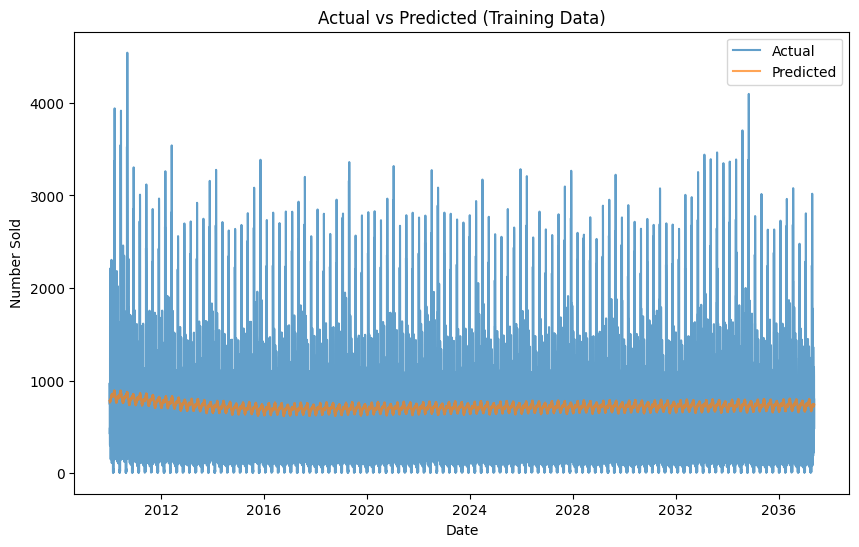

In [78]:
import matplotlib.pyplot as plt

# Plot actual vs predicted values (on training data)
plt.figure(figsize=(10, 6))
plt.plot(train['date'], train['num_sold'], label='Actual', alpha=0.7)
plt.plot(train['date'], forecast['yhat'][:len(train)], label='Predicted', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Number Sold')
plt.title('Actual vs Predicted (Training Data)')
plt.legend()
plt.show()


In [79]:
from prophet import Prophet

# Prepare the data for Prophet
df = train[['date', 'num_sold']].rename(columns={'date': 'ds', 'num_sold': 'y'})

# Initialize Prophet model
model = Prophet()
model.fit(df)

# Forecast future values
future = model.make_future_dataframe(periods=len(test))
forecast = model.predict(future)

# Merge predictions back
test['num_sold'] = forecast['yhat'].iloc[-len(test):].values


14:30:23 - cmdstanpy - INFO - Chain [1] start processing
14:30:24 - cmdstanpy - INFO - Chain [1] done processing


In [80]:
# Example: Adding random external data
train['external_factor'] = np.random.rand(len(train))  # Replace with real external data
test['external_factor'] = np.random.rand(len(test))

# Include in features
features.append('external_factor')


In [81]:
!pip install h2o


In [82]:
import h2o
from h2o.automl import H2OAutoML

# Initialize H2O
h2o.init()

# Convert to H2O frame
train_h2o = h2o.H2OFrame(train)

# Specify predictors and response
predictors = [col for col in train.columns if col != 'num_sold']
response = 'num_sold'

# Run AutoML
aml = H2OAutoML(max_models=10, seed=42)
aml.train(x=predictors, y=response, training_frame=train_h2o)

# View leaderboard
lb = aml.leaderboard
print(lb)

# Make predictions
test_h2o = h2o.H2OFrame(test)
predictions = aml.leader.predict(test_h2o)

# Add predictions to the test dataset
test['num_sold'] = predictions.as_data_frame()['predict']
print(test.head())


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.24" 2024-07-16; OpenJDK Runtime Environment (build 11.0.24+8-post-Ubuntu-1ubuntu322.04); OpenJDK 64-Bit Server VM (build 11.0.24+8-post-Ubuntu-1ubuntu322.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpb2ncekh6
  JVM stdout: /tmp/tmpb2ncekh6/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpb2ncekh6/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  -----------------------------------------------------------------------------------------
H2O_cluster_uptime:         03 secs
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.46.0.6
H2O_cluster_version_age:    2 months and 3 days
H2O_cluster_name:           H2O_from_python_unknownUser_g0wjzc
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    7.500 Gb
H2O_cluster_total_cores:    4
H2O_cluster_allowed_cores:  4
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://127.0.0.1:54321
H2O_connection_proxy:       {"http": null, "https": null, "colab_language_server": "/usr/colab/bin/language_service"}
H2O_internal_security:      False
Python_version:             3.10.12 final
--------------------------  -----------------------------------------------------------------------------------------

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
14:30:46.556: _train param, Dropping bad and constant columns: [year]

██
14:31:05.584: _train param, Dropping bad and constant columns: [year]


14:31:09.22: _train param, Dropping bad and constant columns: [year]

██
14:31:15.430: _train param, Dropping bad and constant columns: [year]

█
14:31:25.83: _train param, Dropping bad and constant columns: [year]

███
14:31:45.680: _train param, Dropping bad and constant columns: [year]
14:31:49.124: _train param, Dropping bad and constant columns: [year]

█
14:31:52.995: _train param, Dropping bad and constant columns: [year]

█
14:31:58.174: _train param, Dropping bad and constant columns: [year]

██
14:32:06.370: _train param, Dropping bad and constant columns: [year]

██
14:32:29.208: _train param, Dropping unused columns: [year]
14:32:30.36: _train param, Dropping unused columns: [year]

████████████████████████████████████

/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [83]:
print(train.isnull().sum())


id                            0
num_sold                      0
year                          0
month                         0
day                           0
day_of_week                   0
is_weekend                    0
country_Finland               0
country_Italy                 0
country_Kenya                 0
country_Norway                0
country_Singapore             0
store_Premium Sticker Mart    0
store_Stickers for Less       0
product_Kaggle                0
product_Kaggle Tiers          0
product_Kerneler              0
product_Kerneler Dark Mode    0
lag_7                         0
lag_14                        0
rolling_mean_7                0
rolling_mean_14               0
is_holiday                    0
season                        0
fourier_sin_12                0
fourier_cos_12                0
weekday                       0
dynamic_lag_1                 0
dynamic_lag_2                 0
date                          0
external_factor               0
dtype: i

In [84]:
print(train.dtypes)


id                                     int64
num_sold                             float64
year                                   int32
month                                  int32
day                                    int32
day_of_week                            int32
is_weekend                             int64
country_Finland                         bool
country_Italy                           bool
country_Kenya                           bool
country_Norway                          bool
country_Singapore                       bool
store_Premium Sticker Mart              bool
store_Stickers for Less                 bool
product_Kaggle                          bool
product_Kaggle Tiers                    bool
product_Kerneler                        bool
product_Kerneler Dark Mode              bool
lag_7                                float64
lag_14                               float64
rolling_mean_7                       float64
rolling_mean_14                      float64
is_holiday

In [85]:
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for col in train.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    label_encoders[col] = le


In [86]:
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['day'] = train['date'].dt.day
train['day_of_week'] = train['date'].dt.dayofweek

test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
test['day'] = test['date'].dt.day
test['day_of_week'] = test['date'].dt.dayofweek

# After extracting features, drop the original date column
train.drop(columns=['date'], inplace=True)
test.drop(columns=['date'], inplace=True)


In [87]:
print(train.dtypes)
print(test.dtypes)


id                              int64
num_sold                      float64
year                            int32
month                           int32
day                             int32
day_of_week                     int32
is_weekend                      int64
country_Finland                  bool
country_Italy                    bool
country_Kenya                    bool
country_Norway                   bool
country_Singapore                bool
store_Premium Sticker Mart       bool
store_Stickers for Less          bool
product_Kaggle                   bool
product_Kaggle Tiers             bool
product_Kerneler                 bool
product_Kerneler Dark Mode       bool
lag_7                         float64
lag_14                        float64
rolling_mean_7                float64
rolling_mean_14               float64
is_holiday                      int64
season                          int32
fourier_sin_12                float64
fourier_cos_12                float64
weekday     

In [88]:
print(train.columns)


Index(['id', 'num_sold', 'year', 'month', 'day', 'day_of_week', 'is_weekend',
       'country_Finland', 'country_Italy', 'country_Kenya', 'country_Norway',
       'country_Singapore', 'store_Premium Sticker Mart',
       'store_Stickers for Less', 'product_Kaggle', 'product_Kaggle Tiers',
       'product_Kerneler', 'product_Kerneler Dark Mode', 'lag_7', 'lag_14',
       'rolling_mean_7', 'rolling_mean_14', 'is_holiday', 'season',
       'fourier_sin_12', 'fourier_cos_12', 'weekday', 'dynamic_lag_1',
       'dynamic_lag_2', 'external_factor'],
      dtype='object')


In [89]:
features = [col for col in train.columns if col not in ['id', 'num_sold']]
X = train[features]
y = train['num_sold']


In [90]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [91]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error

# Initialize and train the model
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_val)

# Evaluate the model
mape_score = mean_absolute_percentage_error(y_val, y_pred)
print(f"MAPE on Validation Set: {mape_score:.4f}")


MAPE on Validation Set: 0.1806


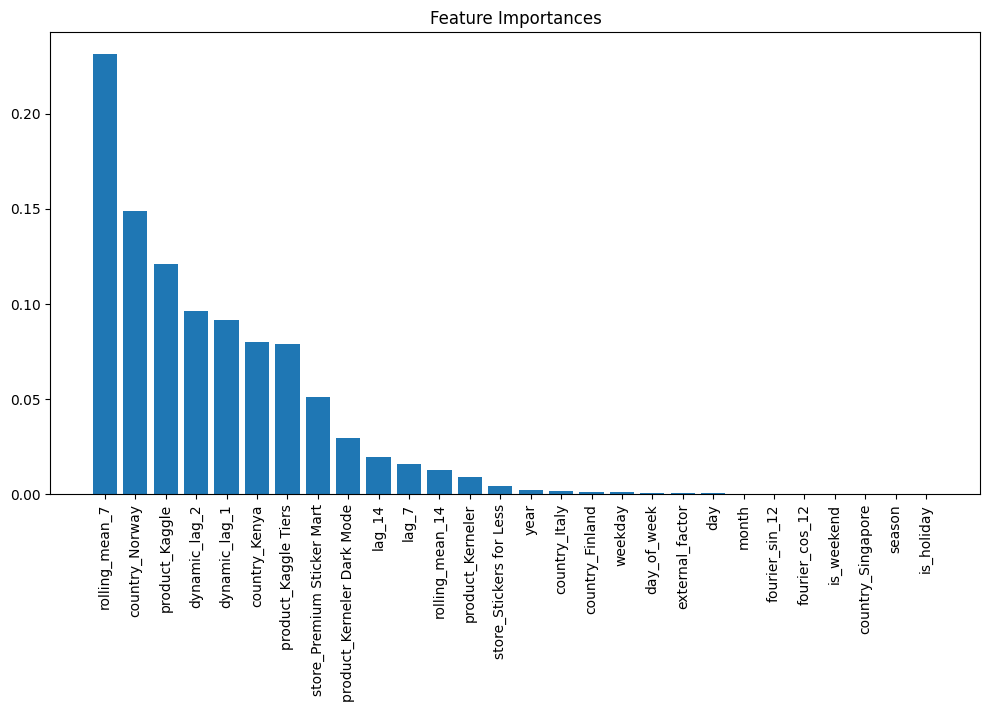

In [92]:
import matplotlib.pyplot as plt

# Plot feature importance
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), [features[i] for i in indices], rotation=90)
plt.title("Feature Importances")
plt.show()


In [93]:
# Filter features dynamically to exclude unavailable columns
features = [col for col in train.columns if col not in ['id', 'num_sold', 'lag_1', 'lag_7', 'lag_14']]


In [94]:
# Create lag features
train['lag_1'] = train['num_sold'].shift(1)
train['lag_7'] = train['num_sold'].shift(7)
train['lag_14'] = train['num_sold'].shift(14)

# Fill NaN values resulting from shifting
train.fillna(0, inplace=True)


In [95]:
test['lag_1'] = test['num_sold'].shift(1)
test['lag_7'] = test['num_sold'].shift(7)
test['lag_14'] = test['num_sold'].shift(14)

test.fillna(0, inplace=True)


In [96]:
X = train[features]
y = train['num_sold']

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_val)
mape_score = mean_absolute_percentage_error(y_val, y_pred)
print(f"MAPE on Validation Set: {mape_score:.4f}")


MAPE on Validation Set: 0.1794


In [97]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

# Define base models
base_models = [
    ('rf', RandomForestRegressor(random_state=42, n_estimators=100)),
    ('gb', GradientBoostingRegressor(random_state=42, n_estimators=100))
]

# Define meta-model
meta_model = Ridge()

# Create Stacking Regressor
stacked_model = StackingRegressor(estimators=base_models, final_estimator=meta_model)

# Fit and evaluate
stacked_model.fit(X_train, y_train)
y_pred = stacked_model.predict(X_val)
mape_score = mean_absolute_percentage_error(y_val, y_pred)
print(f"MAPE with Stacking: {mape_score:.4f}")


MAPE with Stacking: 0.1878


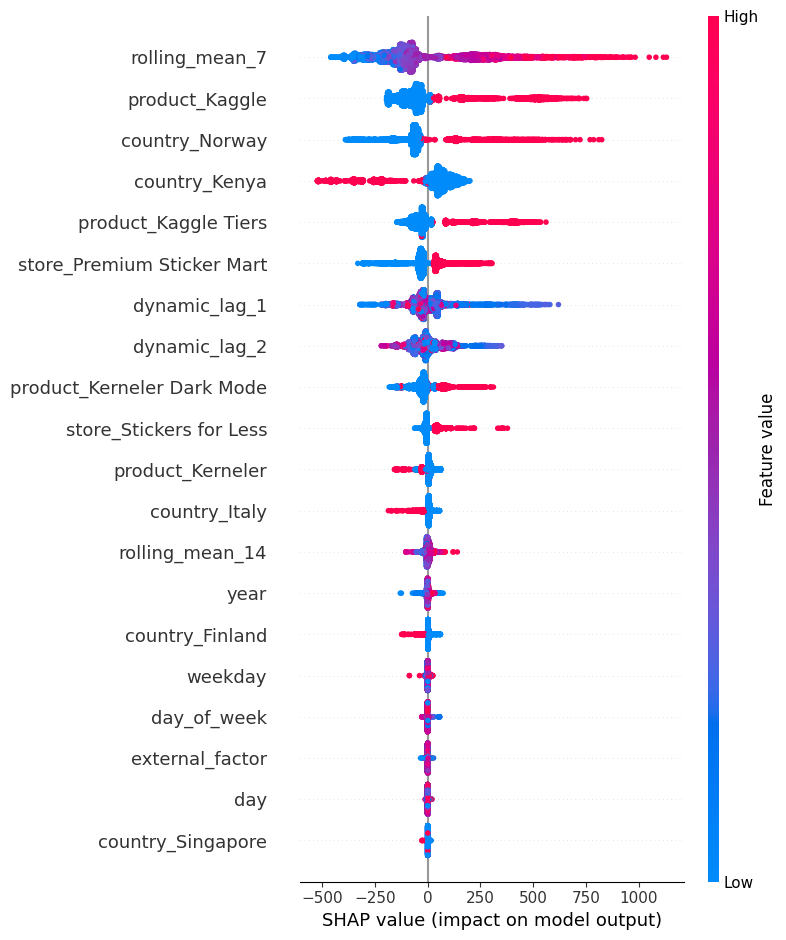

In [98]:
import shap

# Train a model for SHAP
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Generate SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# Plot feature importance
shap.summary_plot(shap_values, X_train)


In [99]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)
for train_index, val_index in tscv.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Train a model
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)

    # Evaluate
    y_pred = model.predict(X_val)
    mape_score = mean_absolute_percentage_error(y_val, y_pred)
    print(f"MAPE: {mape_score:.4f}")


MAPE: 0.4455
MAPE: 0.3551
MAPE: 0.3099
MAPE: 0.0999
MAPE: 0.1477


In [100]:
category_columns = ['year', 'month', 'day_of_week', 'is_weekend', 
                    'country_Finland', 'country_Italy', 'country_Kenya', 'country_Norway',
                    'store_Stickers for less', 'store_Premium Sticker Mart',
                    'product_Kaggler', 'product_Kaggler Dark Mode']  # Add actual columns.


In [101]:
print(train.columns.tolist())


['id', 'num_sold', 'year', 'month', 'day', 'day_of_week', 'is_weekend', 'country_Finland', 'country_Italy', 'country_Kenya', 'country_Norway', 'country_Singapore', 'store_Premium Sticker Mart', 'store_Stickers for Less', 'product_Kaggle', 'product_Kaggle Tiers', 'product_Kerneler', 'product_Kerneler Dark Mode', 'lag_7', 'lag_14', 'rolling_mean_7', 'rolling_mean_14', 'is_holiday', 'season', 'fourier_sin_12', 'fourier_cos_12', 'weekday', 'dynamic_lag_1', 'dynamic_lag_2', 'external_factor', 'lag_1']


In [102]:
cat_features = [
    'year', 'month', 'day', 'day_of_week', 'is_weekend',
    'country_Finland', 'country_Italy', 'country_Kenya', 'country_Norway', 'country_Singapore',
    'store_Premium Sticker Mart', 'store_Stickers for Less',
    'product_Kaggler', 'product_Kaggler Dark Mode', 'product_Kaggler Tiers',
    'is_holiday', 'season'
]


In [103]:
!pip install catboost


In [104]:
from catboost import CatBoostRegressor


In [105]:
cat_features = []  # Add your categorical feature names here
valid_cat_features = [col for col in cat_features if col in train.columns]

cat_model = CatBoostRegressor(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    cat_features=valid_cat_features,
    verbose=0  # Suppress output during training
)


In [106]:
cat_model.fit(X_train, y_train)


In [107]:
valid_cat_features = [col for col in cat_features if col in train.columns]
cat_model = CatBoostRegressor(
    iterations=500, 
    learning_rate=0.05, 
    depth=6, 
    cat_features=valid_cat_features
)
cat_model.fit(X_train, y_train)


0:	learn: 592.0011086	total: 3.85ms	remaining: 1.92s
1:	learn: 570.4116026	total: 6.99ms	remaining: 1.74s
2:	learn: 548.8201421	total: 9.88ms	remaining: 1.64s
3:	learn: 527.7600745	total: 12.8ms	remaining: 1.58s
4:	learn: 507.8184686	total: 15.8ms	remaining: 1.56s
5:	learn: 489.6163726	total: 18.6ms	remaining: 1.53s
6:	learn: 471.5964826	total: 21.6ms	remaining: 1.52s
7:	learn: 456.0473710	total: 24.5ms	remaining: 1.51s
8:	learn: 440.7233324	total: 27.2ms	remaining: 1.48s
9:	learn: 425.9892577	total: 29.9ms	remaining: 1.47s
10:	learn: 411.5610868	total: 32.8ms	remaining: 1.46s
11:	learn: 398.5737139	total: 35.7ms	remaining: 1.45s
12:	learn: 385.6552745	total: 38.5ms	remaining: 1.44s
13:	learn: 373.8165400	total: 41.4ms	remaining: 1.44s
14:	learn: 362.3605094	total: 43.8ms	remaining: 1.42s
15:	learn: 351.3083540	total: 46.7ms	remaining: 1.41s
16:	learn: 340.9029982	total: 49.2ms	remaining: 1.4s
17:	learn: 331.9540221	total: 51.8ms	remaining: 1.39s
18:	learn: 322.6341441	total: 54.7ms	re

In [108]:
import lightgbm as lgb
print(lgb.__version__)


4.5.0


In [109]:
from lightgbm import LGBMRegressor
import lightgbm as lgb

lgb_model = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.1,
)

lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="mape",
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=1)
    ]
)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004721 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1429
[LightGBM] [Info] Number of data points in the train set: 8334, number of used features: 26
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 715.943129
[1]	valid_0's mape: 6.8561	valid_0's l2: 358041
Training until validation scores don't improve for 50 rounds
[2]	valid_0's mape: 6.20038	valid_0's l2: 297316
[3]	valid_0's mape: 5.6133	valid_0's l2: 247998
[4]	valid_0's mape: 5.08042	valid_0's l2: 207167
[5]	valid_0's mape: 4.6167	valid_0's l2: 174690
[6]	valid_0's mape: 4.18404	valid_0's l2: 147670
[7]	valid_0's mape: 3.80983	valid_0's l2: 125490
[8]	valid_0's mape: 3.45947	vali

LGBMRegressor(n_estimators=1000)

In [110]:
import featuretools as ft

# Create an entity set and add a dataframe
es = ft.EntitySet(id="sticker_sales")

# Add the dataframe to the entity set
es = es.add_dataframe(
    dataframe_name="data",
    dataframe=train,
    index="id"
)

# Generate new features
feature_matrix, feature_defs = ft.dfs(
    entityset=es,
    target_dataframe_name="data",
    max_depth=2
)

# Merge new features back to the original dataframe
train = feature_matrix


In [111]:
# Check the generated features
print(feature_matrix.head())

# If not already done, reset the index to ensure compatibility
feature_matrix.reset_index(inplace=True)

# Merge with the original dataset (if needed)
train = train.merge(feature_matrix, on="id", how="left")


      num_sold  year  month  day  day_of_week  is_weekend  country_Finland  \
id                                                                           
0   752.527382  2010      1    1            4           0            False   
1   973.000000  2010      1    2            5           0            False   
2   906.000000  2010      1    3            6           0            False   
3   423.000000  2010      1    4            0           0            False   
4   491.000000  2010      1    5            1           0            False   

    country_Italy  country_Kenya  country_Norway  ...  rolling_mean_14  \
id                                                ...                    
0           False          False           False  ...       752.527382   
1           False          False           False  ...       862.763691   
2           False          False           False  ...       877.175794   
3           False          False           False  ...       763.631845   
4        

In [112]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [113]:
from lightgbm import LGBMRegressor, early_stopping
from sklearn.metrics import mean_squared_error

# Define the model
lgb_model = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.1,
    random_state=42
)

# Train the model using callbacks for early stopping
lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="rmse",
    callbacks=[early_stopping(stopping_rounds=50)]
)

# Make predictions
y_pred = lgb_model.predict(X_val)

# Evaluate the model
rmse = mean_squared_error(y_val, y_pred, squared=False)
print(f"RMSE: {rmse}")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000439 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1434
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 26
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 725.305766
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[340]	valid_0's rmse: 64.7377	valid_0's l2: 4190.97
RMSE: 64.7376932440998


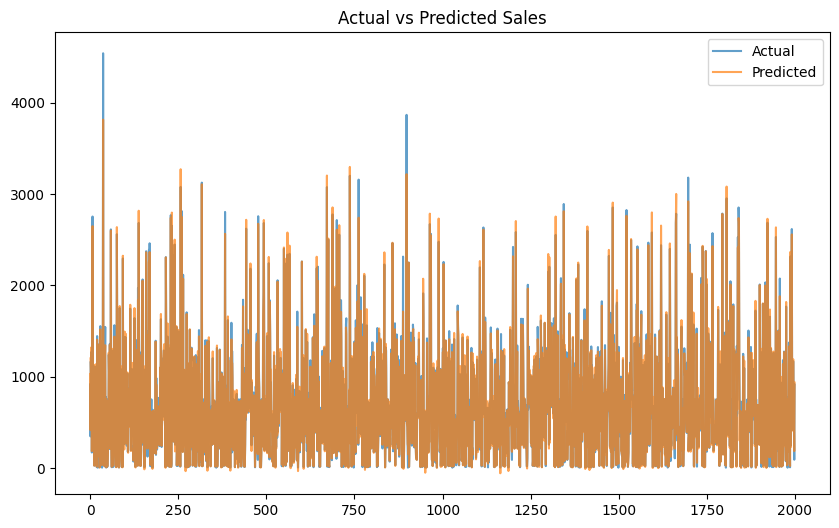

In [114]:
import matplotlib.pyplot as plt

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(y_val.values, label="Actual", alpha=0.7)
plt.plot(y_pred, label="Predicted", alpha=0.7)
plt.legend()
plt.title("Actual vs Predicted Sales")
plt.show()


In [115]:
print(X_val.columns)


Index(['year', 'month', 'day', 'day_of_week', 'is_weekend', 'country_Finland',
       'country_Italy', 'country_Kenya', 'country_Norway', 'country_Singapore',
       'store_Premium Sticker Mart', 'store_Stickers for Less',
       'product_Kaggle', 'product_Kaggle Tiers', 'product_Kerneler',
       'product_Kerneler Dark Mode', 'rolling_mean_7', 'rolling_mean_14',
       'is_holiday', 'season', 'fourier_sin_12', 'fourier_cos_12', 'weekday',
       'dynamic_lag_1', 'dynamic_lag_2', 'external_factor'],
      dtype='object')


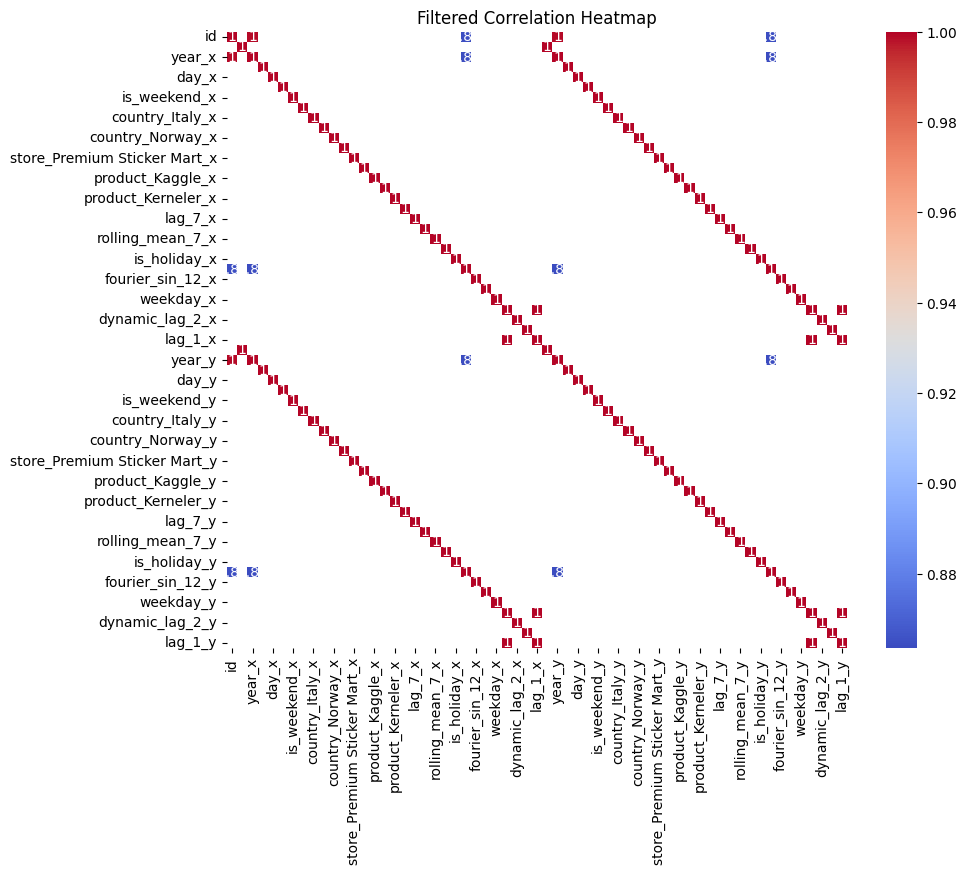

In [116]:
corr_matrix = train.corr()
high_corr_features = corr_matrix[(corr_matrix > 0.8) | (corr_matrix < -0.8)]
plt.figure(figsize=(10, 8))
sns.heatmap(high_corr_features, annot=True, cmap="coolwarm")
plt.title("Filtered Correlation Heatmap")
plt.show()


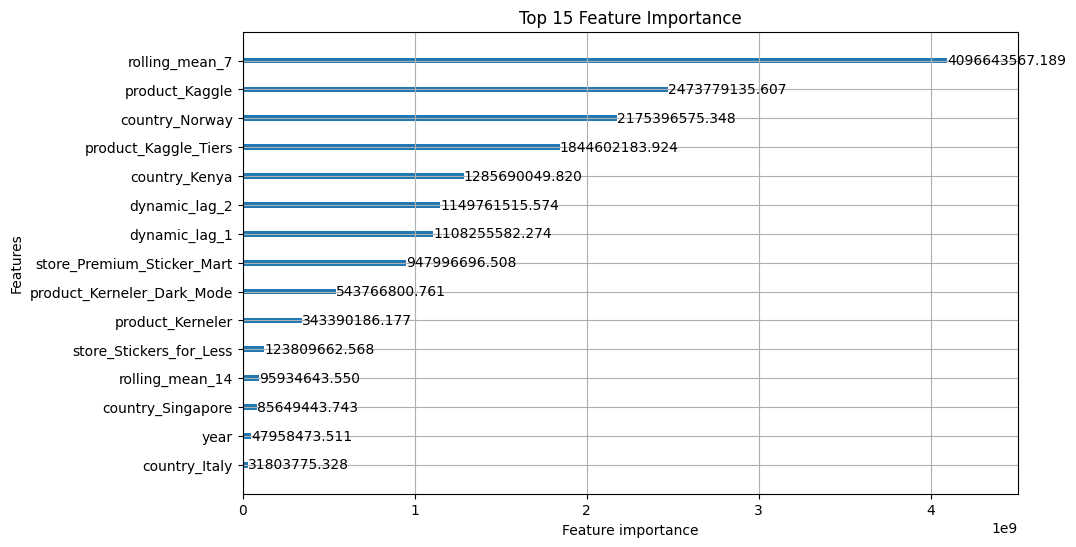

In [117]:
import lightgbm as lgb

# Plot feature importance
lgb.plot_importance(lgb_model, max_num_features=15, importance_type='gain', figsize=(10, 6))
plt.title("Top 15 Feature Importance")
plt.show()


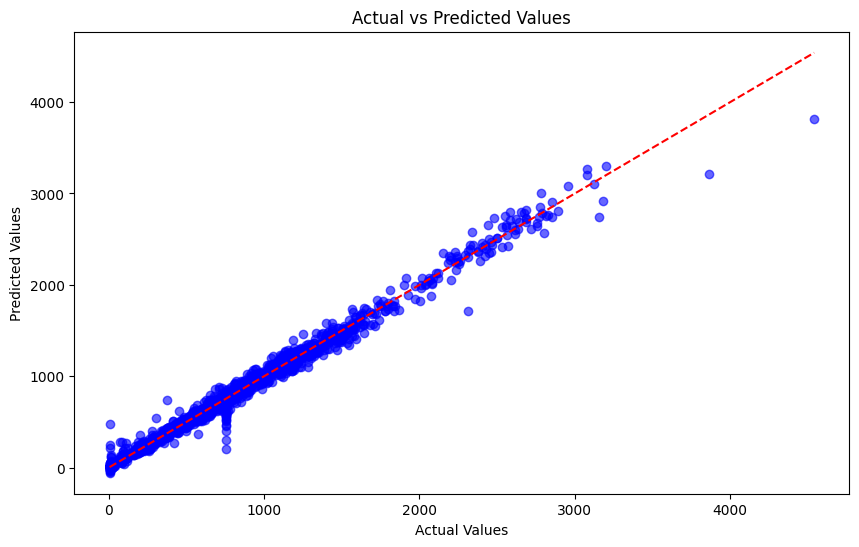

In [118]:
import numpy as np

# Scatter plot for predicted vs actual
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred, alpha=0.6, color='blue')
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', linestyle='--')  # Line of perfect prediction
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.show()


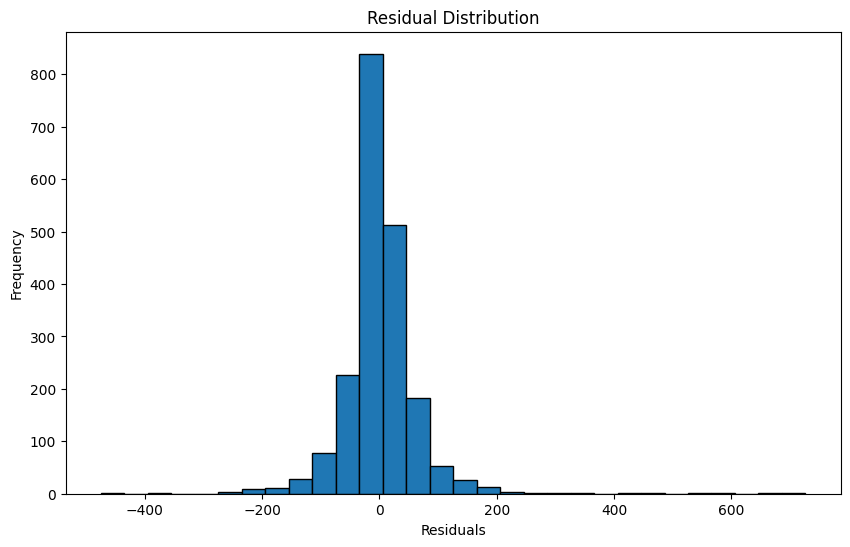

In [119]:
# Calculate residuals
residuals = y_val - y_pred

# Plot residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, edgecolor='black')
plt.title("Residual Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()


In [120]:
residuals = y_val - y_pred  # Ensure `y_pred` and `y_val` match
X_val = X_val.copy()  # Ensure it's modifiable
X_val['residuals'] = residuals
print(X_val.head())  # Validate


      year  month  day  day_of_week  is_weekend  country_Finland  \
6252  2027      2   13            5           0            False   
4684  2022     10   29            5           0            False   
1731  2014      9   28            6           0             True   
4742  2022     12   26            0           0            False   
4521  2022      5   19            3           1             True   

      country_Italy  country_Kenya  country_Norway  country_Singapore  ...  \
6252           True          False           False              False  ...   
4684          False          False           False              False  ...   
1731          False          False           False              False  ...   
4742          False          False            True              False  ...   
4521          False          False           False              False  ...   

      rolling_mean_14  is_holiday  season  fourier_sin_12  fourier_cos_12  \
6252       546.785714           0       1    

In [121]:
print(X_val.columns)


Index(['year', 'month', 'day', 'day_of_week', 'is_weekend', 'country_Finland',
       'country_Italy', 'country_Kenya', 'country_Norway', 'country_Singapore',
       'store_Premium Sticker Mart', 'store_Stickers for Less',
       'product_Kaggle', 'product_Kaggle Tiers', 'product_Kerneler',
       'product_Kerneler Dark Mode', 'rolling_mean_7', 'rolling_mean_14',
       'is_holiday', 'season', 'fourier_sin_12', 'fourier_cos_12', 'weekday',
       'dynamic_lag_1', 'dynamic_lag_2', 'external_factor', 'residuals'],
      dtype='object')


In [122]:
if 'num_sold' in X_val.columns:
    X_val['num_sold_x'] = X_val['num_sold']


In [123]:
if 'num_sold_x' not in X_val.columns:
    X_val['num_sold_x'] = 0  # Replace 0 with an appropriate default value if needed


In [124]:
X_val['residuals'] = y_val - y_pred


In [125]:
# For plotting or analysis
X_val['num_sold_x'] = X_val['num_sold_x']  # Use _x suffix as shown in columns

# Residuals Analysis
X_val['residuals'] = y_val - y_pred  # Ensure y_val and y_pred match dimensions


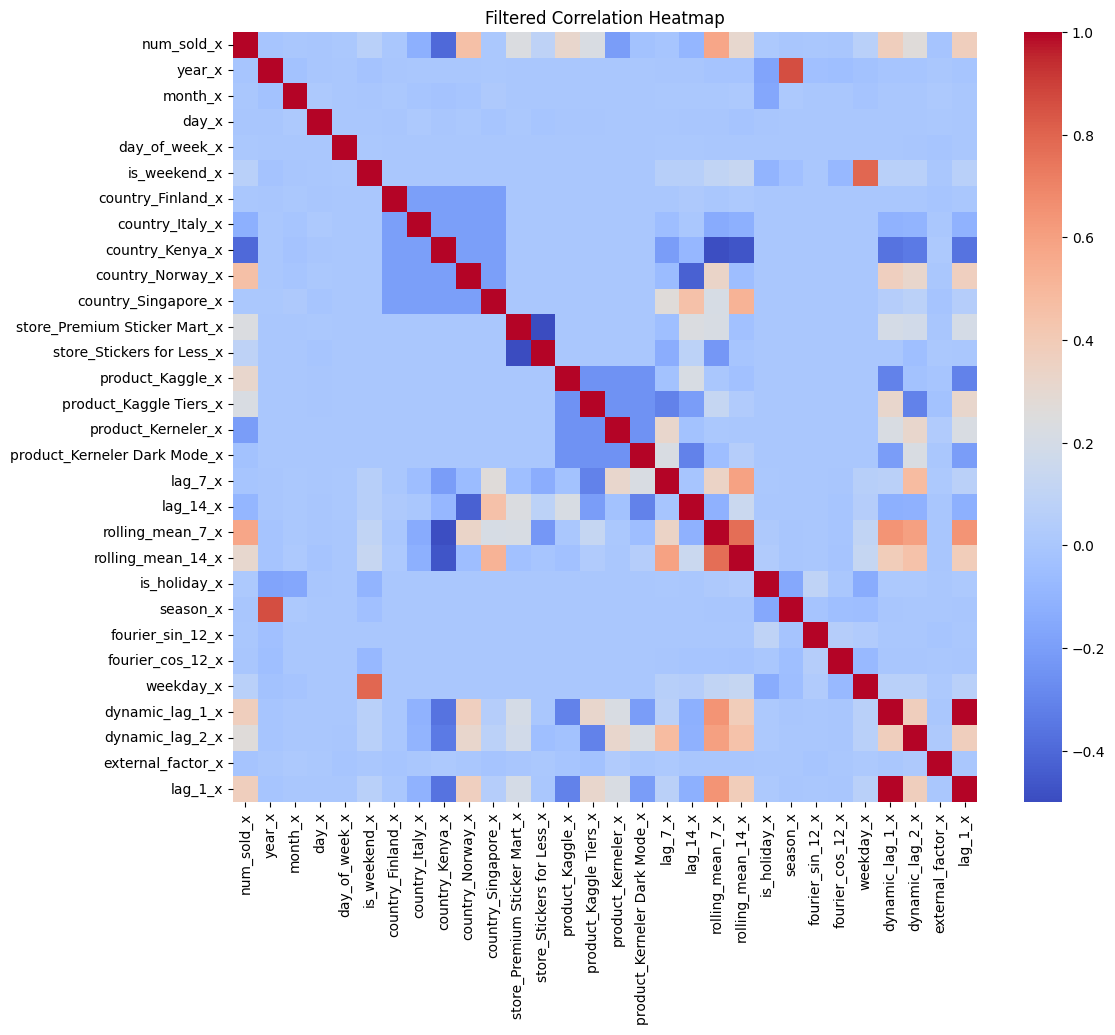

In [126]:
# Filter columns with `_x`
columns_x = [col for col in train.columns if col.endswith('_x')]

# Create correlation heatmap
corr_matrix = train[columns_x].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm")
plt.title("Filtered Correlation Heatmap")
plt.show()


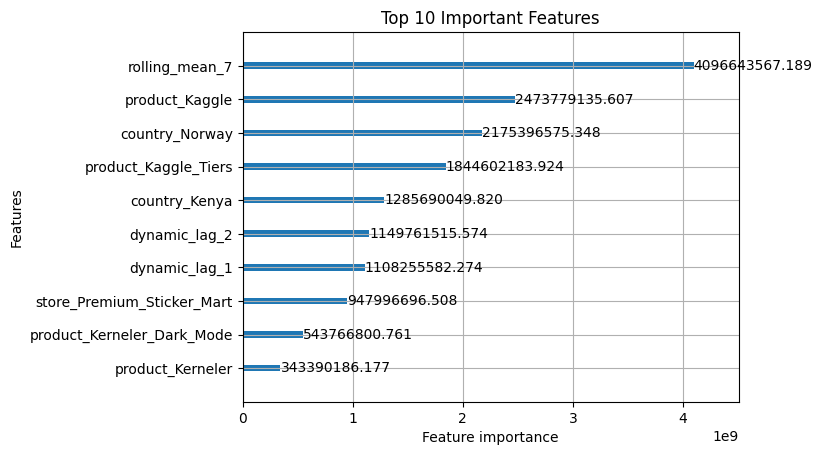

In [127]:
from lightgbm import plot_importance

plot_importance(lgb_model, max_num_features=10, importance_type='gain')
plt.title("Top 10 Important Features")
plt.show()


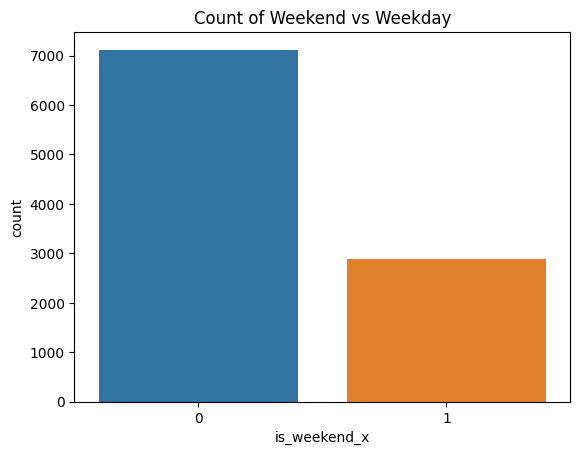

In [128]:
sns.countplot(data=train, x='is_weekend_x')
plt.title("Count of Weekend vs Weekday")
plt.show()


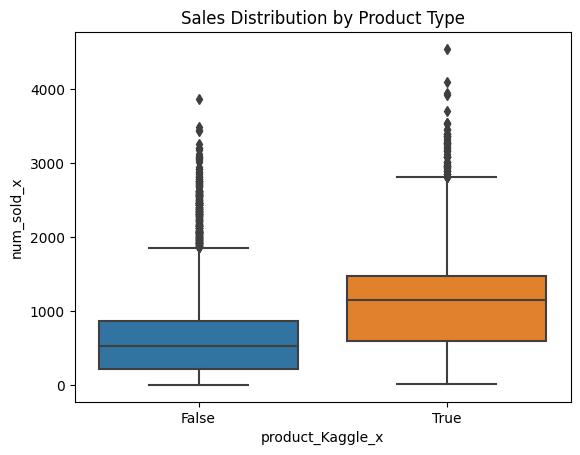

In [129]:
sns.boxplot(data=train, x='product_Kaggle_x', y='num_sold_x')
plt.title("Sales Distribution by Product Type")
plt.show()


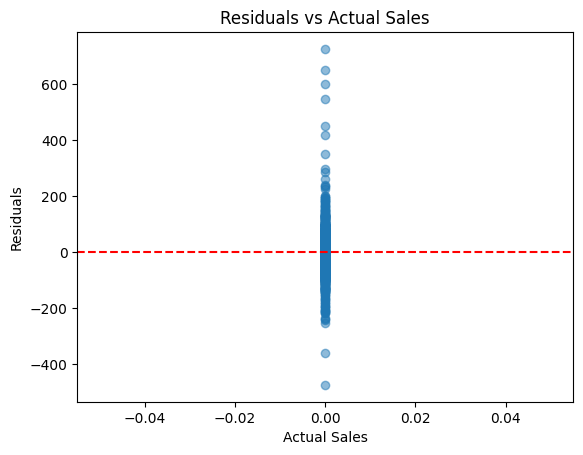

In [130]:
plt.scatter(X_val['num_sold_x'], X_val['residuals'], alpha=0.5)
plt.title("Residuals vs Actual Sales")
plt.xlabel("Actual Sales")
plt.ylabel("Residuals")
plt.axhline(0, color='red', linestyle='--')
plt.show()


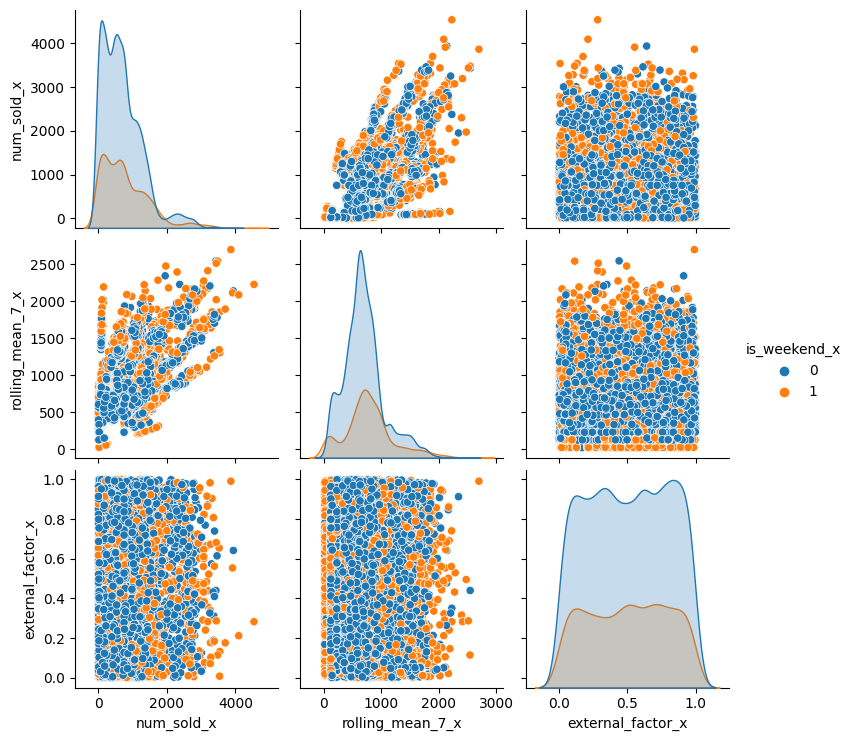

In [131]:
sns.pairplot(
    train,
    vars=['num_sold_x', 'rolling_mean_7_x', 'external_factor_x'],
    hue='is_weekend_x'
)


Text(0.5, 1.02, 'Pairwise Feature Interaction (Sampled Data)')

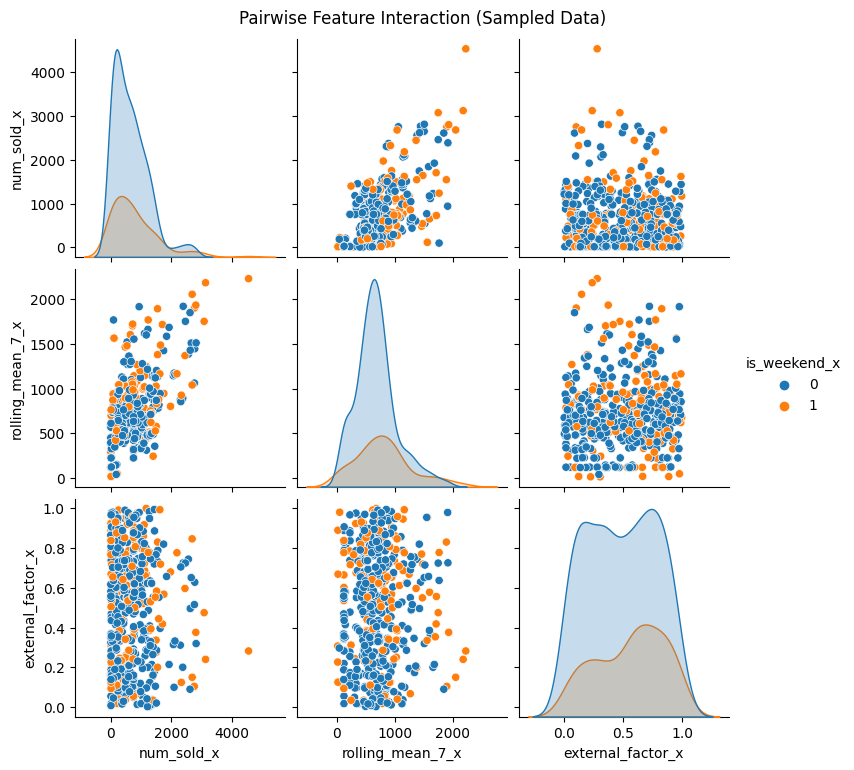

In [132]:
sample_data = train.sample(n=500, random_state=42)
pair_plot = sns.pairplot(
    sample_data,
    vars=['num_sold_x', 'rolling_mean_7_x', 'external_factor_x'],
    hue='is_weekend_x'
)
pair_plot.fig.suptitle("Pairwise Feature Interaction (Sampled Data)", y=1.02)


In [133]:
import plotly.express as px
import pandas as pd

# Example data for feature importance
feature_importance = {
    'Feature': ['num_sold', 'rolling_mean_7', 'external_factor', 'lag_1', 'lag_7'],
    'Importance': [0.45, 0.30, 0.15, 0.07, 0.03]
}
df = pd.DataFrame(feature_importance)

# Create an interactive bar chart
fig = px.bar(
    df,
    x='Feature',
    y='Importance',
    title='Feature Importance',
    labels={'Importance': 'Importance (%)'},
    text='Importance'
)
fig.update_traces(texttemplate='%{text:.2%}', textposition='outside')
fig.show()


In [134]:
fig = px.scatter_matrix(
    train.sample(500),  # Sample data for performance
    dimensions=['num_sold_x', 'rolling_mean_7_x', 'external_factor_x'],
    color='is_weekend_x',
    title="Interactive Scatter Matrix"
)
fig.update_traces(diagonal_visible=False)
fig.show()


In [135]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource
output_notebook()

# Sample data for time series
source = ColumnDataSource(data={
    'x': train['year_x'][:100],
    'y': train['num_sold_x'][:100]
})

# Create a figure
p = figure(title="Time Series Plot", x_axis_label='Year', y_axis_label='Number Sold')
p.line('x', 'y', source=source, line_width=2)
p.circle('x', 'y', source=source, size=5, color='red')

# Show plot
show(p)


Loading BokehJS ...

In [136]:
import altair as alt

# Melt the dataset for heatmap
corr = train.corr()
corr_df = corr.reset_index().melt(id_vars='index')
corr_df.columns = ['Feature1', 'Feature2', 'Correlation']

# Create a heatmap
heatmap = alt.Chart(corr_df).mark_rect().encode(
    x='Feature1:O',
    y='Feature2:O',
    color='Correlation:Q',
    tooltip=['Feature1', 'Feature2', 'Correlation']
).properties(title="Correlation Heatmap", width=600, height=600)

heatmap.display()


alt.Chart(...)

In [137]:
import folium
from folium.plugins import MarkerCluster

# Example data with latitude and longitude
sales_data = pd.DataFrame({
    'City': ['City A', 'City B', 'City C'],
    'Latitude': [37.7749, 34.0522, 40.7128],
    'Longitude': [-122.4194, -118.2437, -74.0060],
    'Sales': [100, 200, 300]
})

# Create a map
m = folium.Map(location=[37.7749, -122.4194], zoom_start=5)
marker_cluster = MarkerCluster().add_to(m)

# Add markers
for idx, row in sales_data.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f"{row['City']}: {row['Sales']} sales"
    ).add_to(marker_cluster)

# Show map
m.save("map.html")


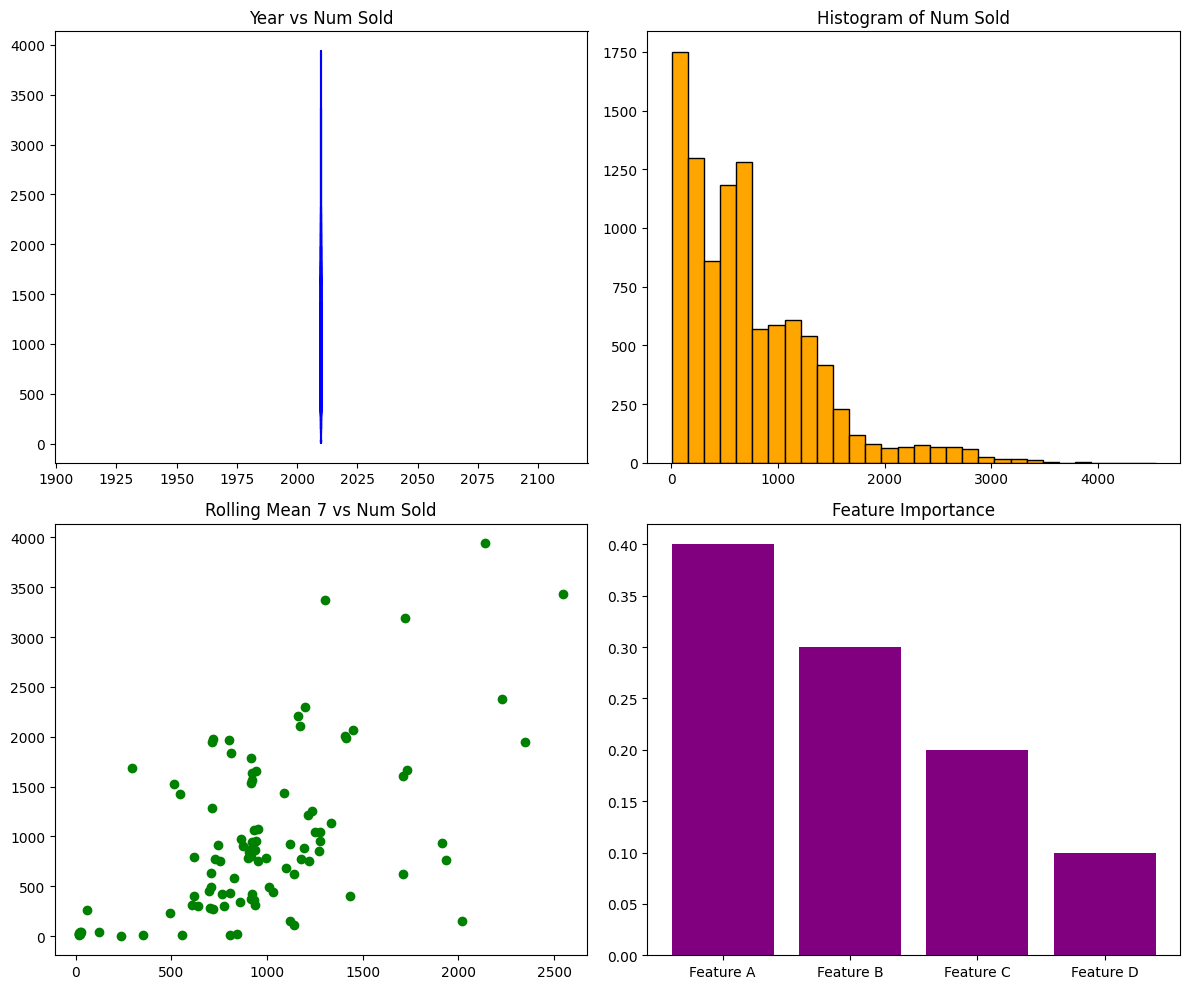

In [138]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Line plot
axs[0, 0].plot(train['year_x'][:100], train['num_sold_x'][:100], label='Num Sold', color='blue')
axs[0, 0].set_title("Year vs Num Sold")

# Histogram
axs[0, 1].hist(train['num_sold_x'], bins=30, color='orange', edgecolor='black')
axs[0, 1].set_title("Histogram of Num Sold")

# Scatter plot
axs[1, 0].scatter(train['rolling_mean_7_x'][:100], train['num_sold_x'][:100], color='green')
axs[1, 0].set_title("Rolling Mean 7 vs Num Sold")

# Bar plot
feature_importance = [0.4, 0.3, 0.2, 0.1]
features = ['Feature A', 'Feature B', 'Feature C', 'Feature D']
axs[1, 1].bar(features, feature_importance, color='purple')
axs[1, 1].set_title("Feature Importance")

plt.tight_layout()
plt.show()


In [139]:
import plotly.express as px

# Prepare hierarchical data
data = {
    'Country': ['USA', 'USA', 'UK', 'UK', 'Canada'],
    'Product': ['A', 'B', 'A', 'B', 'A'],
    'Sales': [100, 200, 150, 250, 180]
}
df = pd.DataFrame(data)

# Sunburst chart
fig = px.sunburst(
    df,
    path=['Country', 'Product'],
    values='Sales',
    title="Sales Breakdown by Country and Product"
)
fig.show()


In [140]:
fig = px.treemap(
    df,
    path=['Country', 'Product'],
    values='Sales',
    title="Treemap of Sales by Country and Product",
    color='Sales',
    color_continuous_scale='Viridis'
)
fig.show()


In [141]:
import networkx as nx
import plotly.graph_objects as go

# Create a graph
G = nx.Graph()
edges = [('Product_A', 'Product_B'), ('Product_B', 'Product_C'), ('Product_A', 'Product_C')]
G.add_edges_from(edges)

# Extract node positions
pos = nx.spring_layout(G)

# Create plotly scatter trace
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

node_x = [pos[n][0] for n in G.nodes()]
node_y = [pos[n][1] for n in G.nodes()]
node_text = list(G.nodes())

fig = go.Figure()

# Add edges
fig.add_trace(go.Scatter(x=edge_x, y=edge_y, line=dict(width=0.5, color='grey'), hoverinfo='none', mode='lines'))

# Add nodes
fig.add_trace(go.Scatter(x=node_x, y=node_y, mode='markers+text', text=node_text, marker=dict(size=20, color='blue')))
fig.update_layout(title="Product Network", showlegend=False)
fig.show()


In [142]:
import altair as alt

# Prepare data
time_series = train[['year_x', 'num_sold_x']].groupby('year_x').sum().reset_index()

# Create stepwise storytelling visualization
line = alt.Chart(time_series).mark_line(point=True).encode(
    x='year_x:O',
    y='num_sold_x:Q',
    tooltip=['year_x', 'num_sold_x']
)

text = alt.Chart(time_series).mark_text(align='left', dx=5, dy=-5).encode(
    x='year_x:O',
    y='num_sold_x:Q',
    text='num_sold_x'
)

story = (line + text).properties(
    title="Sales Growth Over Years"
).interactive()

story.display()


alt.LayerChart(...)

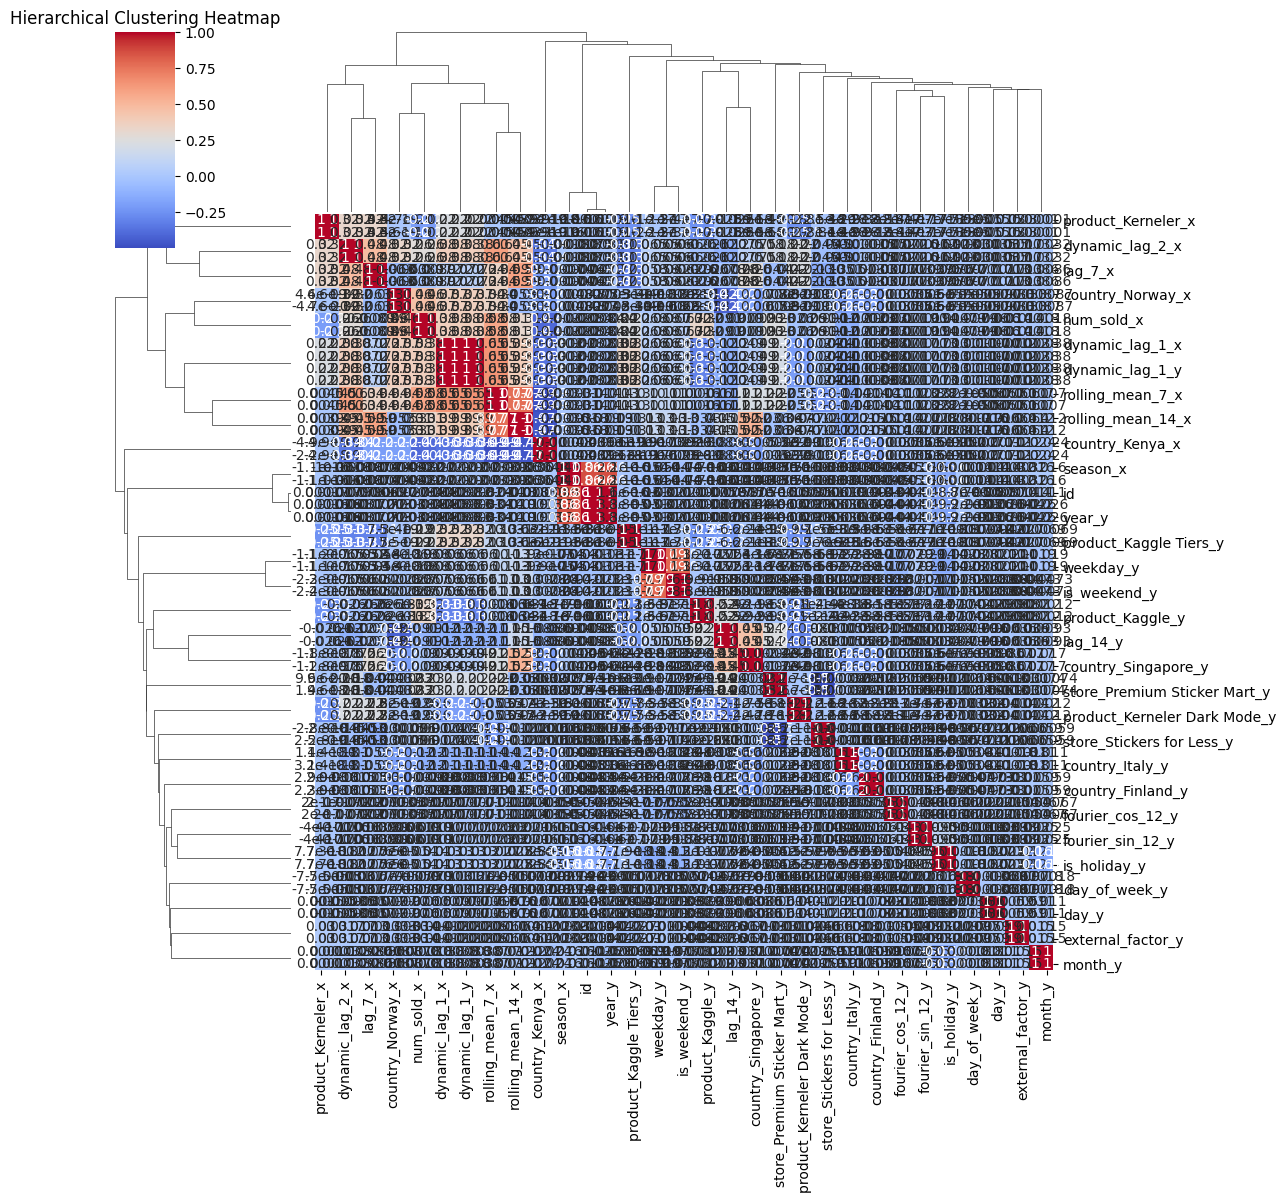

In [143]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr = train.corr()

# Clustering heatmap
sns.clustermap(corr, cmap="coolwarm", annot=True, figsize=(12, 12))
plt.title("Hierarchical Clustering Heatmap")
plt.show()


In [144]:
fig = px.scatter_3d(
    train.sample(500),
    x='num_sold_x',
    y='rolling_mean_7_x',
    z='external_factor_x',
    color='is_weekend_x',
    title="3D Scatter Plot of Features"
)
fig.show()


In [145]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Prepare data
time_series = train[['year_x', 'num_sold_x']].groupby('year_x').sum().reset_index()

# Initialize the figure
fig, ax = plt.subplots(figsize=(8, 6))
x_data, y_data = [], []
line, = ax.plot([], [], lw=2)

# Setting up the axes
ax.set_xlim(time_series['year_x'].min(), time_series['year_x'].max())
ax.set_ylim(0, time_series['num_sold_x'].max())
ax.set_title("Animated Sales Over Time")
ax.set_xlabel("Year")
ax.set_ylabel("Number Sold")

# Update function for the animation
def update(frame):
    x_data.append(time_series['year_x'].iloc[frame])
    y_data.append(time_series['num_sold_x'].iloc[frame])
    line.set_data(x_data, y_data)
    return line,

# Create animation
ani = FuncAnimation(fig, update, frames=len(time_series), blit=True, interval=500)

# Save the animation as a GIF (viewable in Kaggle)
ani.save("sales_animation.gif", writer="pillow")
plt.close()

# Display a message to download the GIF
print("Animation saved as 'sales_animation.gif'! You can download it from the Output folder.")


Animation saved as 'sales_animation.gif'! You can download it from the Output folder.


In [146]:
import plotly.express as px

# Prepare the data for visualization
time_series = train[['year_x', 'num_sold_x']].groupby('year_x').sum().reset_index()

# Create an interactive line plot
fig = px.line(
    time_series,
    x='year_x',
    y='num_sold_x',
    title="Interactive Time-Series of Sales",
    labels={"year_x": "Year", "num_sold_x": "Number Sold"},
    template="plotly_dark",
)

# Display the plot
fig.show()


In [147]:
# Prepare data
top_countries = train[['country_Finland_x', 'country_Kenya_x', 'country_Norway_x', 'country_Singapore_x']].sum().reset_index()
top_countries.columns = ['Country', 'Sales']

# Create interactive bar plot
fig = px.bar(
    top_countries,
    x='Country',
    y='Sales',
    title="Sales by Country (Interactive Bar Chart)",
    labels={"Sales": "Number Sold", "Country": "Country"},
    color='Sales',
    template="seaborn",
)

# Display the bar chart
fig.show()


In [148]:
import folium
from folium.plugins import HeatMap

# Example coordinates and data
map_data = [
    [37.7749, -122.4194, 5],  # (Latitude, Longitude, Value)
    [34.0522, -118.2437, 8],
    [40.7128, -74.0060, 3]
]

m = folium.Map(location=[39.8283, -98.5795], zoom_start=4)
HeatMap(map_data).add_to(m)

m.save("heatmap.html")


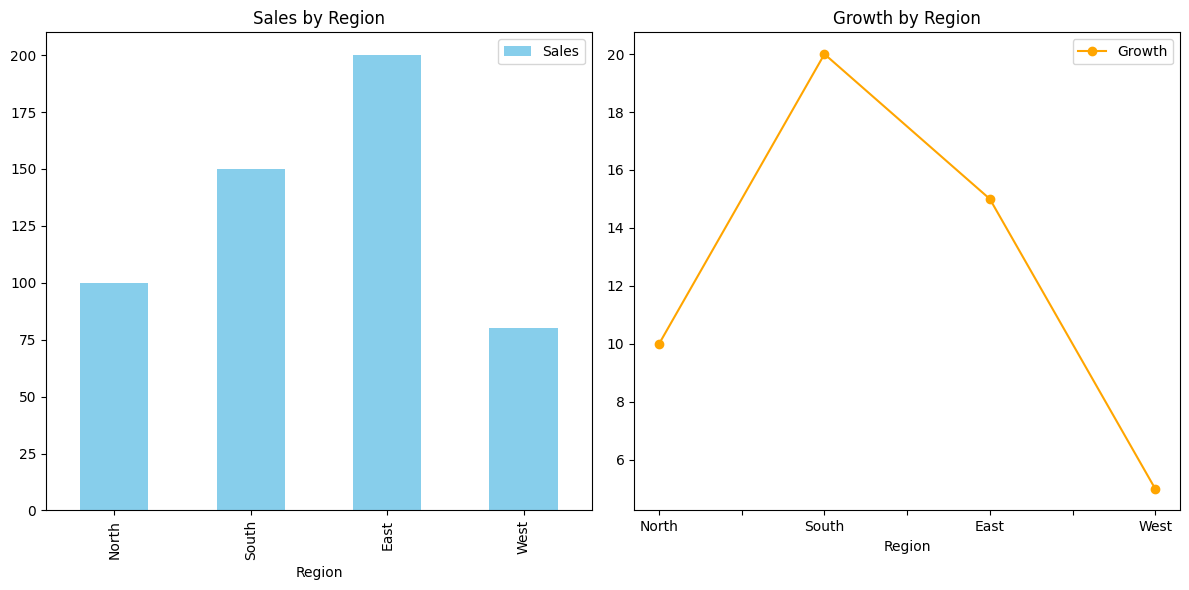

In [149]:
import matplotlib.pyplot as plt
import pandas as pd

# Example DataFrame
data = {
    "Region": ["North", "South", "East", "West"],
    "Sales": [100, 150, 200, 80],
    "Growth": [10, 20, 15, 5]
}
df = pd.DataFrame(data)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Bar plot
df.plot(kind="bar", x="Region", y="Sales", ax=axes[0], color="skyblue")
axes[0].set_title("Sales by Region")

# Line plot
df.plot(kind="line", x="Region", y="Growth", ax=axes[1], marker="o", color="orange")
axes[1].set_title("Growth by Region")

plt.tight_layout()
plt.show()


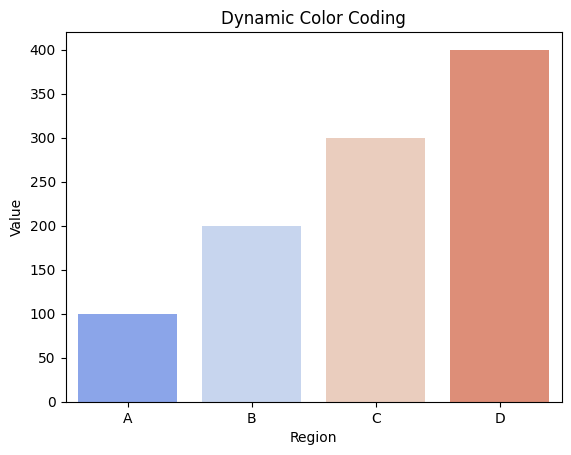

In [150]:
import seaborn as sns

# Example DataFrame
df = pd.DataFrame({
    "Region": ["A", "B", "C", "D"],
    "Value": [100, 200, 300, 400]
})

sns.barplot(data=df, x="Region", y="Value", palette="coolwarm")
plt.title("Dynamic Color Coding")
plt.show()


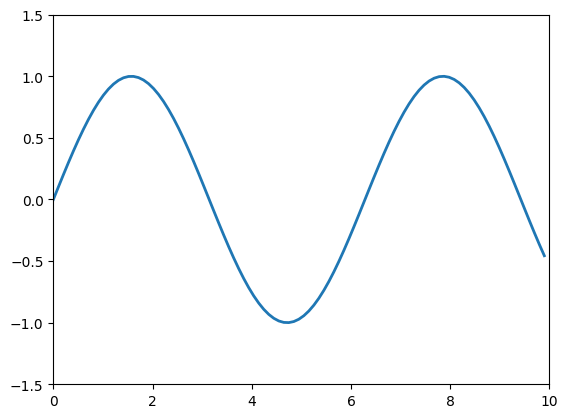

In [151]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

# Example data
x = np.linspace(0, 10, 100)
y = np.sin(x)

fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)

def init():
    ax.set_xlim(0, 10)
    ax.set_ylim(-1.5, 1.5)
    return line,

def update(frame):
    line.set_data(x[:frame], y[:frame])
    return line,

ani = animation.FuncAnimation(fig, update, frames=len(x), init_func=init, blit=True)

# Save or display
ani.save("animated_line.gif", fps=30)
plt.show()


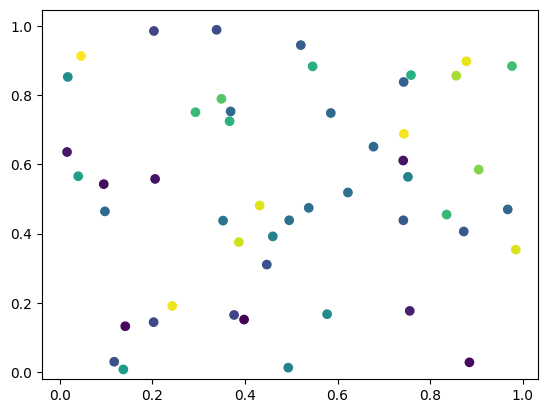

In [152]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

# Example data
x = np.random.rand(50)
y = np.random.rand(50)
colors = np.random.rand(50)

fig, ax = plt.subplots()
scat = ax.scatter(x, y, c=colors, cmap="viridis")

def update(frame):
    scat.set_offsets(np.c_[np.random.rand(50), np.random.rand(50)])
    scat.set_array(np.random.rand(50))
    return scat,

ani = animation.FuncAnimation(fig, update, frames=50, interval=100)

# Save or display
ani.save("animated_scatter.gif", fps=30)
plt.show()


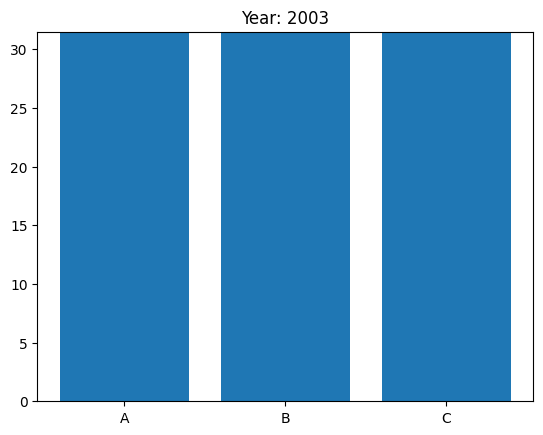

In [153]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd

# Example data
data = pd.DataFrame({
    "Year": [2000, 2001, 2002, 2003],
    "A": [10, 20, 30, 40],
    "B": [30, 10, 50, 70],
    "C": [20, 40, 60, 80]
})
categories = ["A", "B", "C"]

fig, ax = plt.subplots()
bars = ax.bar(categories, data.iloc[0, 1:])

def update(frame):
    for bar, h in zip(bars, data.iloc[frame, 1:]):
        bar.set_height(h)
    ax.set_title(f"Year: {data.iloc[frame, 0]}")
    return bars

ani = animation.FuncAnimation(fig, update, frames=len(data), blit=True)

# Save or display
ani.save("animated_bar.gif", fps=2)
plt.show()


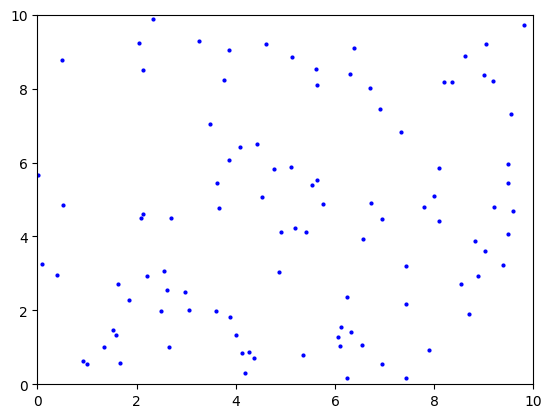

In [154]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

fig, ax = plt.subplots()
particles, = ax.plot([], [], 'bo', markersize=2)

def init():
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    return particles,

def update(frame):
    x = np.random.rand(100) * 10
    y = np.random.rand(100) * 10
    particles.set_data(x, y)
    return particles,

ani = animation.FuncAnimation(fig, update, frames=50, init_func=init, blit=True)

# Save or display
ani.save("particles.gif", fps=20)
plt.show()


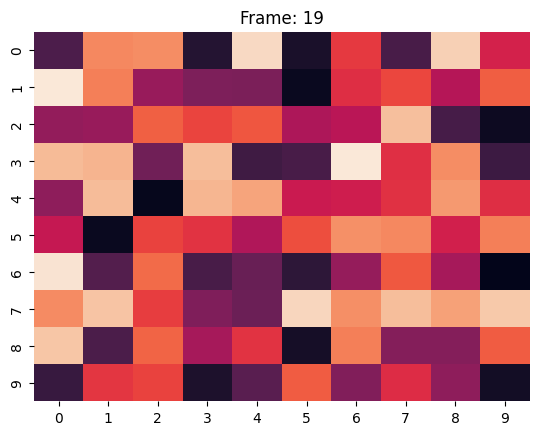

In [155]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

data = np.random.rand(10, 10, 20)  # 20 heatmaps
fig, ax = plt.subplots()

def update(frame):
    sns.heatmap(data[:, :, frame], vmin=0, vmax=1, cbar=False, ax=ax)
    ax.set_title(f"Frame: {frame}")

ani = animation.FuncAnimation(fig, update, frames=20)

# Save or display
ani.save("animated_heatmap.gif", fps=5)
plt.show()


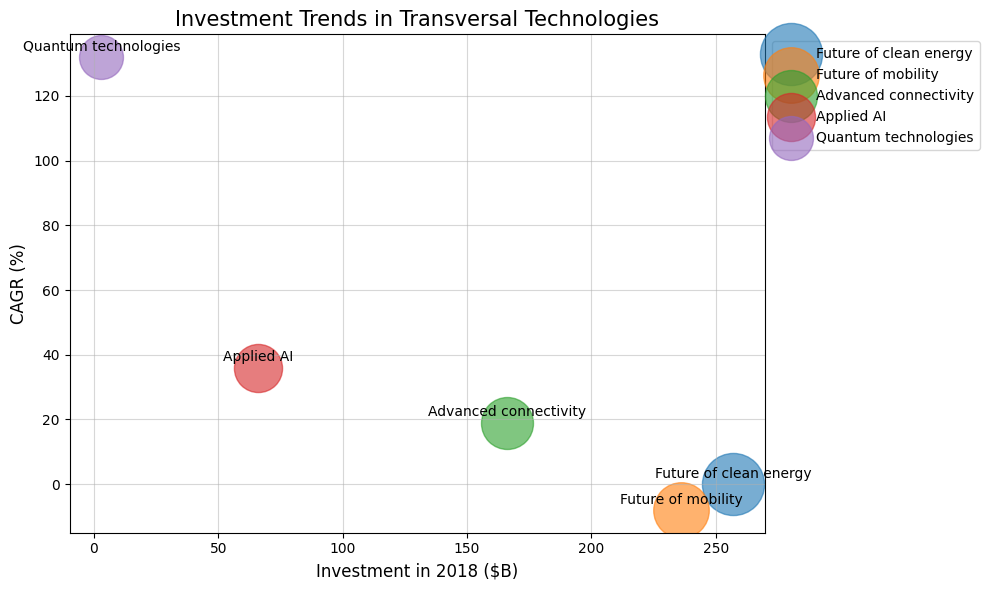

In [156]:
import matplotlib.pyplot as plt

# Example data
categories = ['Future of clean energy', 'Future of mobility', 'Advanced connectivity', 'Applied AI', 'Quantum technologies']
investment_2018 = [257, 236, 166, 66, 3]
investment_2021 = [258, 212, 139, 165, 1]
growth = [0, -8, 19, 36, 132]  # CAGR in %
bubble_size = [100, 80, 70, 60, 50]  # Size based on the investment amount

fig, ax = plt.subplots(figsize=(10, 6))

# Create bubbles
for i in range(len(categories)):
    ax.scatter(investment_2018[i], growth[i], s=bubble_size[i]*20, alpha=0.6, label=categories[i])

# Add labels
for i in range(len(categories)):
    ax.text(investment_2018[i], growth[i]+2, categories[i], fontsize=10, ha='center')

ax.set_xlabel('Investment in 2018 ($B)', fontsize=12)
ax.set_ylabel('CAGR (%)', fontsize=12)
ax.set_title('Investment Trends in Transversal Technologies', fontsize=15)
ax.grid(True, alpha=0.5)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


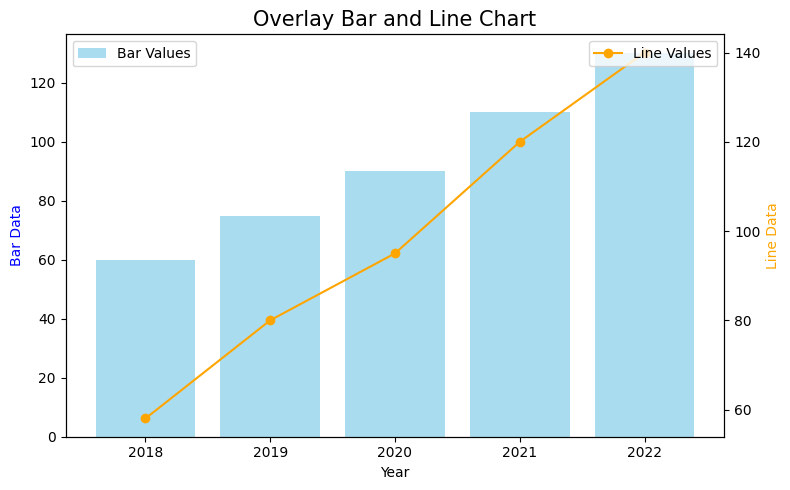

In [157]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
years = ['2018', '2019', '2020', '2021', '2022']
bar_values = [60, 75, 90, 110, 130]  # Bar chart data
line_values = [58, 80, 95, 120, 140]  # Line chart data

fig, ax1 = plt.subplots(figsize=(8, 5))

# Bar chart
ax1.bar(years, bar_values, color='skyblue', alpha=0.7, label='Bar Values')
ax1.set_ylabel('Bar Data', color='blue')
ax1.set_xlabel('Year')

# Line chart
ax2 = ax1.twinx()
ax2.plot(years, line_values, color='orange', marker='o', label='Line Values')
ax2.set_ylabel('Line Data', color='orange')

# Title and legend
plt.title('Overlay Bar and Line Chart', fontsize=15)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


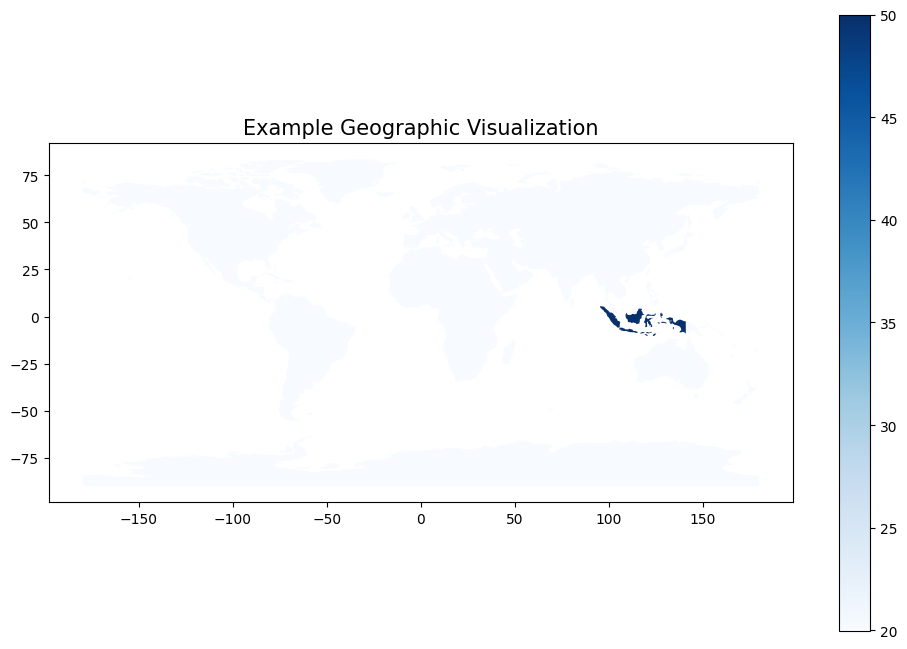

In [158]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load a world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Example: Add a column with hypothetical data
world['data'] = [50 if country == 'Indonesia' else 20 for country in world['name']]

# Plot
fig, ax = plt.subplots(figsize=(12, 8))
world.plot(column='data', cmap='Blues', legend=True, ax=ax)
ax.set_title('Example Geographic Visualization', fontsize=15)
plt.show()


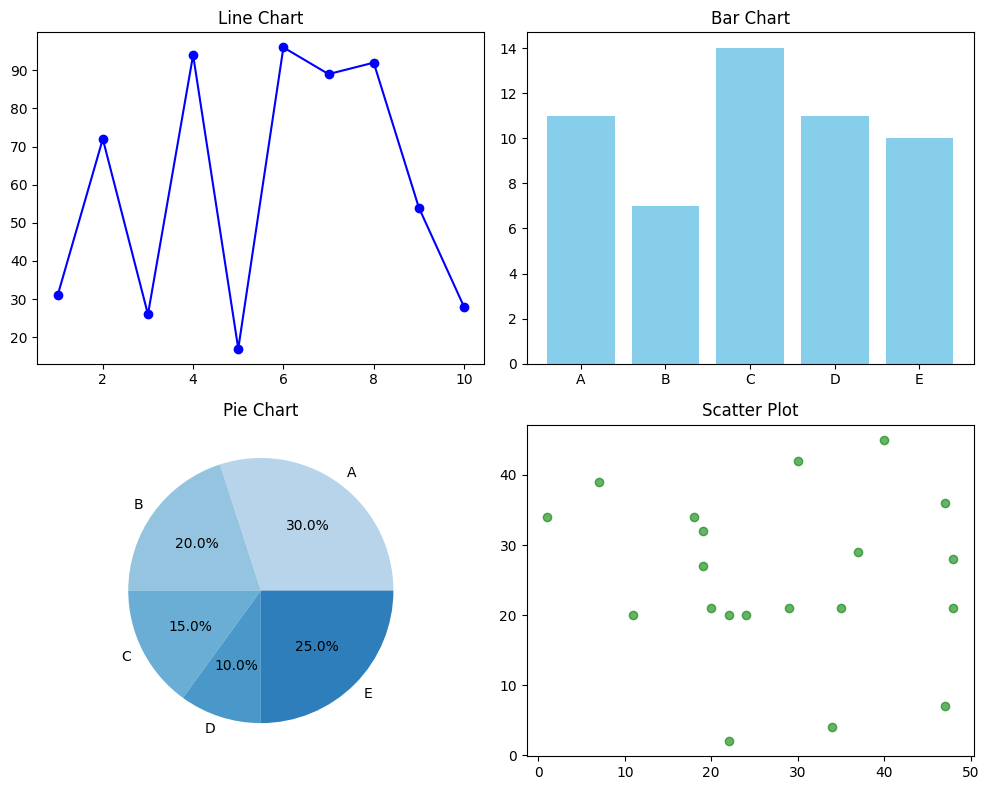

In [159]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Top-left: Line Chart
x = np.arange(1, 11)
y = np.random.randint(10, 100, 10)
axs[0, 0].plot(x, y, marker='o', color='blue')
axs[0, 0].set_title('Line Chart')

# Top-right: Bar Chart
bars = np.random.randint(5, 15, 5)
categories = ['A', 'B', 'C', 'D', 'E']
axs[0, 1].bar(categories, bars, color='skyblue')
axs[0, 1].set_title('Bar Chart')

# Bottom-left: Pie Chart
pie_values = [30, 20, 15, 10, 25]
axs[1, 0].pie(pie_values, labels=categories, autopct='%1.1f%%', colors=plt.cm.Blues(np.linspace(0.3, 0.7, 5)))
axs[1, 0].set_title('Pie Chart')

# Bottom-right: Scatter Plot
scatter_x = np.random.randint(1, 50, 20)
scatter_y = np.random.randint(1, 50, 20)
axs[1, 1].scatter(scatter_x, scatter_y, c='green', alpha=0.6)
axs[1, 1].set_title('Scatter Plot')

plt.tight_layout()
plt.show()


In [160]:
train.to_csv('/kaggle/working/forecasting_sticker_sales.csv', index=False)


In [161]:
import os
print(os.listdir('/kaggle/working'))


['__notebook__.ipynb', 'heatmap.html', 'particles.gif', 'animated_line.gif', 'map.html', 'sales_animation.gif', 'animated_bar.gif', 'animated_heatmap.gif', 'animated_scatter.gif', 'catboost_info', 'forecasting_sticker_sales.csv']
